In [133]:
from pathlib import Path
import numpy as np
import nibabel as nib
import h5py

from matplotlib import pyplot as plt
import importlib
importlib.reload(utils)

<module 'utils' from '/Users/charliehuang/Documents/murthy_lab/projects/on_the_fly/utils.py'>

In [2]:
from src.utils.data_loading import loadSupervoxelData, loadFlyVRData, getFictracSampsAtVolume
from src.utils.regression import makeRegressionData

# Max data paths

In [21]:
DATA_PATH = Path("/Volumes/murthy/Max/upstairs_imaging/nsyb_actuator_imaging/functional")
ANALYSIS_PATH = Path("/Volumes/Charlie's P/Charlie/imaging_analysis")
TRIAL_PATH = ANALYSIS_PATH / "DATA"
TRIAL_PATH.mkdir(exist_ok=True)

In [22]:
# Gets experiment name and paths
experiments = {}
for path in DATA_PATH.glob("**/fictrac"):
    expdir = path.parent
    expname = "_".join(expdir.parts[-2:])
    try:
        supervoxelsPath = next(expdir.glob("**/supervoxels_fda.nii"))
    except StopIteration:
        continue
    experiments[expname] = dict(directory=expdir, supervoxels=supervoxelsPath)

In [23]:
experiments

{'20240612_101': {'directory': PosixPath('/Volumes/murthy/Max/upstairs_imaging/nsyb_actuator_imaging/functional/20240612/101'),
  'supervoxels': PosixPath('/Volumes/murthy/Max/upstairs_imaging/nsyb_actuator_imaging/functional/20240612/101/20240612_101_func/registration/supervoxels_fda.nii')},
 '20240612_201': {'directory': PosixPath('/Volumes/murthy/Max/upstairs_imaging/nsyb_actuator_imaging/functional/20240612/201'),
  'supervoxels': PosixPath('/Volumes/murthy/Max/upstairs_imaging/nsyb_actuator_imaging/functional/20240612/201/20240612_201_func/registration/supervoxels_fda.nii')},
 '20240623_101': {'directory': PosixPath('/Volumes/murthy/Max/upstairs_imaging/nsyb_actuator_imaging/functional/20240623/101'),
  'supervoxels': PosixPath('/Volumes/murthy/Max/upstairs_imaging/nsyb_actuator_imaging/functional/20240623/101/20240623_101_func/registration/supervoxels_fda.nii')},
 '20240623_201': {'directory': PosixPath('/Volumes/murthy/Max/upstairs_imaging/nsyb_actuator_imaging/functional/202406

# Get AOTU and lobula supervoxels

In [5]:
# Read region ROIs
roisFDA = {}
with open(ANALYSIS_PATH / "FDA" / "roisFDA.txt", "r") as f:
    for line in f.readlines():
        i, region = line.strip(",\n").split(":")
        i = int(i)
        region = region.strip(' "')
        roisFDA[i] = region
npil_dict = {v:k for k, v in roisFDA.items()}

In [6]:
# Load FDA
neuropilPath = ANALYSIS_PATH / "FDA" / "20240926_FDA_rois_iso38.nii"
neuropilLabels = nib.load(neuropilPath).get_fdata(dtype=np.float32).astype(np.int32)

In [7]:
neuropilMasks = {}
for neuropil in ("LO_L", "LO_R", "AOTU_L", "AOTU_R"):
    neuropilMasks[neuropil] = neuropilLabels == npil_dict[neuropil]

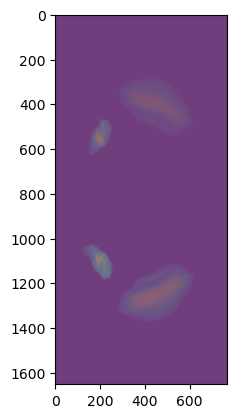

In [8]:
for mask in neuropilMasks.values():
    plt.imshow(mask.sum(axis=2), alpha=0.3)

In [9]:
# xyz coordinates of each voxel in a neuropil
neuropilSparse = {}
for neuropil, mask in neuropilMasks.items():
    neuropilSparse[neuropil] = np.column_stack(np.where(mask))

In [10]:
# Find supervoxels belonging to a given neuropil

def get_neuropil_supervoxels(labels, neuropil):
    svxs = np.unique(labels[tuple(neuropilSparse[neuropil].T)])
    return svxs[svxs > 0]

def get_supervoxel_centroids(labels, svxs):
    flat = labels.flatten()  # flatten supervoxel labels
    indices = np.arange(len(flat))  # raveled indices
    in_svxs = np.isin(flat, svxs)  # find where labels in supervoxels
    flat, indices = flat[in_svxs], indices[in_svxs]

    centroids = []
    for sv in svxs:
        xyz = np.array(np.unravel_index(indices[flat == sv], labels.shape))
        centroids.append(xyz.mean(axis=1))
    return np.array(centroids)

# Don't RUN

In [ ]:
# for name, info in experiments.items():
#     # Create output path
#     print(name)

#     # Load supervoxels
#     supervoxelsPath = info["supervoxels"]
#     supervoxelLabels = nib.load(supervoxelsPath).get_fdata(dtype=np.float32).astype(np.int32)
#     assert neuropilLabels.shape == supervoxelLabels.shape

#     # Get neuropil supervoxels
#     neuropilSupervoxels = {}
#     for neuropil in neuropilMasks.keys():
#         print("\t" + neuropil)
#         svxs = get_neuropil_supervoxels(supervoxelLabels, neuropil)
#         centroids = get_supervoxel_centroids(supervoxelLabels, svxs)
#         neuropilSupervoxels[neuropil] = dict(ids=svxs, centroids=centroids)

#     # Save
#     with h5py.File(TRIAL_PATH / f"{name}.h5", "w") as f:
#         for neuropil, neuropil_info in neuropilSupervoxels.items():
#             grp = f.create_group(neuropil)
#             for k, vals in neuropil_info.items():
#                 grp.create_dataset(k, data=vals)

# Save imaging data

In [24]:
for name, info in experiments.items():
    print(name)
    # Skip analyzed
    skip = False
    with h5py.File(TRIAL_PATH / f"{name}.h5", "r") as f:
        for neuropil, grp in f.items():
            if "timeseries" in grp:
                skip = True
    if skip:
        continue
    # Load data
    allNeuralData, idxToROI, roiToIdx = loadSupervoxelData(str(info["directory"]), getRaw=False)
    # Save neuropil timeseries
    with h5py.File(TRIAL_PATH / f"{name}.h5", "r+") as f:
        for neuropil, grp in f.items():
            neuropil_idxs = [roiToIdx[svx] for svx in grp["ids"][:]]
            neuropil_data = allNeuralData[neuropil_idxs]
            grp.create_dataset("timeseries", data=neuropil_data)

20240612_101
20240612_201
20240623_101
20240623_201
20240704_101
20240610_101
20240610_201
20240606_102
20240606_101
20240606_201
20240606_202
20240618_102
20240618_101
20240618_201
20240620_101
20240620_201
20240605_102
20240605_101
20240629_101
20240629_201
20240629_301
20240609_101
20240530_201
20240617_101
20240617_201
20240617_401
20240617_301
20240611_101
20240611_201
20240625_101
20240625_201


# Save FlyVR data - no need run

In [ ]:
# actuator_data = {}
# for name, info in experiments.items():
#     print(name)
#     # Load data
#     flyvrData = loadFlyVRData(str(info["directory"]))
#     fsav = getFictracSampsAtVolume(flyvrData)  # video sample at volume
#     regressionData = makeRegressionData(
#     flyvrData=flyvrData,
#     cnnData=None,
#     fictracTimestamps=fsav,
#     featureList=[
#         "mfDistZ",
#         "sideSideZ",
#         "mFSZ",
#         "mRSZ"
#     ],
#     fullLen=False  # False -> imaging timebase; True -> fictrac timebase
# )   # flyvr data in imaging timebase
#     actuator_data[name] = regressionData

20240612_101
Loading flyvr data...
Done!
40
[np.int64(83451), np.int64(90141), np.int64(97002), np.int64(103864), np.int64(110725), np.int64(117587), np.int64(124449), np.int64(131310), np.int64(138172), np.int64(145033), np.int64(151895), np.int64(158757), np.int64(165618), np.int64(172480), np.int64(179341), np.int64(186203), np.int64(193065), np.int64(199926), np.int64(206788), np.int64(213650), np.int64(220511), np.int64(227373), np.int64(234235), np.int64(241096), np.int64(247958), np.int64(254820), np.int64(261681), np.int64(268543), np.int64(275405), np.int64(282266), np.int64(289128), np.int64(295990), np.int64(302851), np.int64(309713), np.int64(316575), np.int64(323436), np.int64(330298), np.int64(337160), np.int64(344021), np.int64(350883), np.int64(357745), np.int64(364606), np.int64(371468), np.int64(378330), np.int64(385191), np.int64(392053), np.int64(398915), np.int64(405777), np.int64(412638), np.int64(419500), np.int64(426362), np.int64(433223), np.int64(440085), np.i

In [ ]:
# with open(pkl_path + 'actuator_data.pkl', 'wb') as file:
#     pkl.dump(actuator_data, file)

# Analysis

In [13]:
import pickle as pkl
pkl_path = "/Volumes/Charlie's P/Charlie/imaging_analysis/pkls/"
with open(pkl_path + 'actuator_data.pkl', 'rb') as file:
    actuator_data = pkl.load(file)

In [25]:
gen_data_dir = "../gen_data/"
with open(gen_data_dir + 'fda_dict_lc10a_left.pkl', 'rb') as f:
    fda_dict_lc10a_left = pkl.load(f)
with open(gen_data_dir + 'fda_dict_lc10a_right.pkl', 'rb') as f:
    fda_dict_lc10a_right = pkl.load(f)
with open(gen_data_dir + 'fda_dict_lc14a_left.pkl', 'rb') as f:
    fda_dict_lc14a_left = pkl.load(f)
with open(gen_data_dir + 'fda_dict_lc14a_right.pkl', 'rb') as f:
    fda_dict_lc14a_right = pkl.load(f)

In [26]:
def load_all_synapses(fda_dict, scale_factor = 2.62):
    all_dendrites = []
    all_boutons = []
    key_list_dends, key_list_bouts = [],[]
    for key in fda_dict.keys():
        all_dendrites.extend(fda_dict[key]['dendrites'])
        all_boutons.extend(fda_dict[key]['boutons'])
        key_list_dends.extend([key]*len(fda_dict[key]['dendrites']))
        key_list_bouts.extend([key]*len(fda_dict[key]['boutons']))
    all_synapses = {'dendrites': scale_factor*np.array(all_dendrites), 'boutons': scale_factor*np.array(all_boutons),
                    'key_list_dends': np.array(key_list_dends), 'key_list_bouts': np.array(key_list_bouts)}
    return all_synapses

lc10a_left_all = load_all_synapses(fda_dict_lc10a_left)
lc10a_right_all = load_all_synapses(fda_dict_lc10a_right)
lc14a_left_all = load_all_synapses(fda_dict_lc14a_left)
lc14a_right_all = load_all_synapses(fda_dict_lc14a_right)

In [16]:
from collections import defaultdict
import gc
gc.collect()
print(TRIAL_PATH)
print(len(actuator_data))

/Volumes/Charlie's P/Charlie/imaging_analysis/DATA
31


In [27]:
data = {}
for name, info in experiments.items():
    print(name)
    neuropils = {}
    with h5py.File(TRIAL_PATH / f"{name}.h5", "r") as f:
        for neuropil, grp in f.items():
            xyz = grp["centroids"][:]
            tseries = grp["timeseries"][:]
            neuropils[neuropil] = xyz, tseries
    if name in actuator_data:
        data[name] = dict(imaging=neuropils)
        data[name].update(actuator_data[name])

20240612_101
20240612_201
20240623_101
20240623_201
20240704_101
20240610_101
20240610_201
20240606_102
20240606_101
20240606_201
20240606_202
20240618_102
20240618_101
20240618_201
20240620_101
20240620_201
20240605_102
20240605_101
20240629_101
20240629_201
20240629_301
20240609_101
20240530_201
20240617_101
20240617_201
20240617_401
20240617_301
20240611_101
20240611_201
20240625_101
20240625_201


In [402]:
exmRSZ = data['20240530_201']['mRSZ']
exmFSZ = data['20240530_201']['mFSZ']
exSideSide = data['20240530_201']['sideSideZ']
exmfDistZ = data['20240530_201']['mfDistZ']
print('behav shape: ', exSideSide.shape, exmfDistZ.shape)

eximg = data['20240530_201']['imaging']['AOTU_R']
print("eximg elem 0: ", eximg[0].shape)
print("DIMENSIONS: Supervoxel x [x,y,z]")
print("eximg elem 1: ", eximg[1].shape)
print("DIMENSIONS: Supervoxel x frame (volume)")

behav shape:  (2623,) (2623,)
eximg elem 0:  (340, 3)
DIMENSIONS: Supervoxel x [x,y,z]
eximg elem 1:  (340, 2623)
DIMENSIONS: Supervoxel x frame (volume)


(0.0, 100.0)

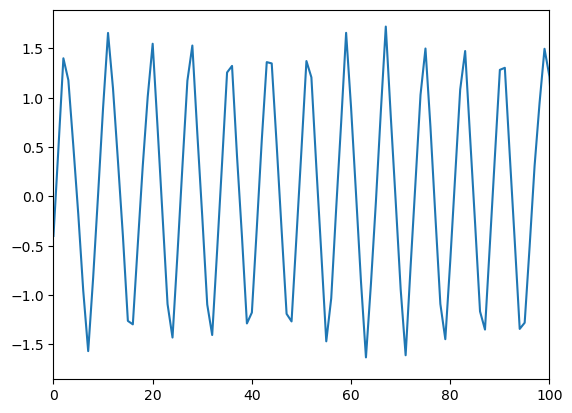

In [327]:
plt.plot(exSideSide, label='sideSideZ')
plt.xlim([0,100])

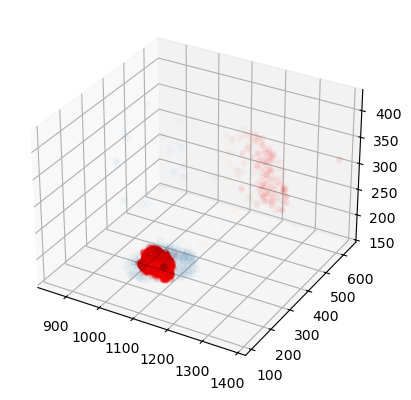

In [238]:
supervox_pos = eximg[0]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*supervox_pos.T, alpha=0.02)

ax.scatter(*lc10a_right_all['boutons'].T, c='r', alpha=0.01, lw=0.1)
ax.scatter(*neuropilCenterDists['AOTU_R'][0], c='k', alpha=1.0)
# eximg[0]

# Neuropil Centers and Thresholding for within AOTU

In [239]:
# averages voxel per neuropil
neuropilCenterDists = {}
for d, neuropil in zip([200, 200, 110, 110], ["LO_R", "LO_L", "AOTU_R", "AOTU_L"]):
    points = neuropilSparse[neuropil]
    c = points.mean(axis=0)
    neuropilCenterDists[neuropil] = (c, d)

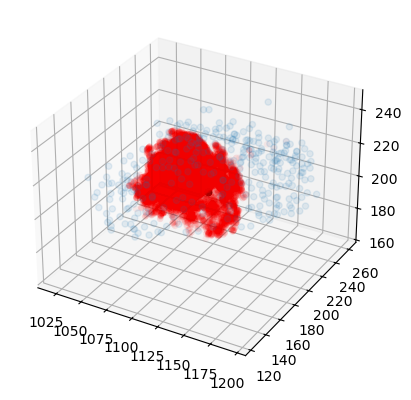

In [240]:
radius = 100
center_oi = neuropilCenterDists['AOTU_R'][0]
supervox_dists = np.linalg.norm(supervox_pos - center_oi, axis=1)
fda_dists = np.linalg.norm(lc10a_right_all['boutons'] - center_oi, axis=1)

inds_fda_aotu_r = np.where(fda_dists <= radius)[0]
inds_supervox_aotu_r = np.where(supervox_dists <= radius)[0]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*supervox_pos[inds_supervox_aotu_r].T, alpha=0.1)
ax.scatter(*lc10a_right_all['boutons'][inds_fda_aotu_r].T, c='r', alpha=0.05, lw=0.1)
ax.scatter(*neuropilCenterDists['AOTU_R'][0], c='k', alpha=1.0)

# Filtering off of Distance

In [241]:
supervox_pos_aotu = supervox_pos[inds_supervox_aotu_r]
subset_keylist = lc10a_right_all['key_list_bouts'][inds_fda_aotu_r]
subset_boutons = lc10a_right_all['boutons'][inds_fda_aotu_r]

# Load in LC10a receptive fields

In [242]:
import pandas as pd
lc10a_rfields_right = pd.read_csv(gen_data_dir + 'LC10a_right_rf_centres.csv', dtype={'root_id':str})
print(lc10a_rfields_right.columns)

Index(['root_id', 'x', 'y'], dtype='object')


In [ ]:
lc10a_rfields_right_dict_temp = {
    str(row['root_id']): (row['x'], row['y'])
    for _, row in lc10a_rfields_right.iterrows()
}

rfields_nankeys_r = [k for k, (xv, yv) in lc10a_rfields_right_dict_temp.items() if np.isnan(xv) or np.isnan(yv)]
inds_rfield_nonan = [i for i,elem in enumerate(subset_keylist) if elem not in rfields_nankeys_r]
subset_boutons = subset_boutons[inds_rfield_nonan]
subset_keylist = subset_keylist[inds_rfield_nonan]

lc10a_rfields_right_dict = {}
for key in lc10a_rfields_right_dict_temp.keys():
    if key not in rfields_nankeys_r:
        lc10a_rfields_right_dict[key] = lc10a_rfields_right_dict_temp[key]
        
print(len(lc10a_rfields_right_dict.keys()), len(lc10a_right_all['key_list_bouts']))

110 26880


(25536, 3)


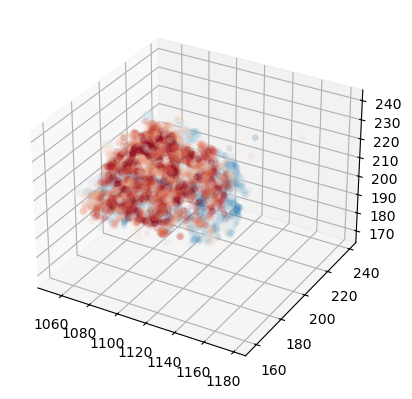

In [305]:
from mpl_toolkits.mplot3d import Axes3D


print(subset_boutons.shape)
subset_rf_centres = np.array([lc10a_rfields_right_dict[k] for k in subset_keylist])
normalize = lambda x: (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x))
normalize_centered = lambda x: x / (np.nanmax(x) - np.nanmin(x))

colors_ap_axis= normalize_centered(subset_rf_centres[:, 0])
colors_dv_axis = normalize_centered(subset_rf_centres[:, 1])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*subset_boutons.T, c=colors_ap_axis, alpha=0.05, lw=0.1, cmap='RdBu')
# ax.scatter(*neuropilCenterDists['AOTU_R'][0], c='k', alpha=1.0)
plt.show()

In [251]:
importlib.reload(utils)

<module 'utils' from '/Users/charliehuang/Documents/murthy_lab/projects/on_the_fly/utils.py'>

In [306]:
import utils

fig = utils.interactive_plot(subset_boutons[:,0], subset_boutons[:,1], subset_boutons[:,2], color_list=colors_ap_axis, title='AOTU_R LC10a Boutons: colored by rfield AP axis', cmap='Spectral_r')
utils.add_to_plot(fig, supervox_pos_aotu[:,0], supervox_pos_aotu[:,1], supervox_pos_aotu[:,2], color_list='grey', opacity=0.2, cmap='Viridis', marker_size=10)
fig.show()

In [307]:
utils.interactive_plot(subset_boutons[:,0], subset_boutons[:,1], subset_boutons[:,2], color_list=colors_dv_axis, title='AOTU_R LC10a Boutons: colored by rfield DV axis')

# Voxel - LC10a - Receptive Fields

In [344]:
#simpler approach

def generate_voxel_rf(supervox_pos_aotu, subset_boutons, colors_ap_axis, colors_dv_axis, radius=10, minlength = 5):
    lengths = []
    voxel_rf = []
    for svox in supervox_pos_aotu:
        dists = np.linalg.norm(subset_boutons - svox, axis=1)
        close_inds = np.where(dists < radius)[0]
        lengths.append(len(close_inds))
        if len(close_inds) < minlength:
            voxel_rf.append([np.nan, np.nan])
        else:
            mean_ap = np.mean(colors_ap_axis[close_inds])
            mean_dv = np.mean(colors_dv_axis[close_inds])
            voxel_rf.append([mean_ap, mean_dv])
    voxel_rf = np.array(voxel_rf)
    print(np.max(lengths))
    return voxel_rf



In [345]:
voxel_rf = generate_voxel_rf(supervox_pos_aotu, subset_boutons, colors_ap_axis, colors_dv_axis, radius=10)
print(np.sum(np.isnan(voxel_rf))/2)

utils.interactive_plot(supervox_pos_aotu[:,0], supervox_pos_aotu[:,1], supervox_pos_aotu[:,2], color_list=voxel_rf[:, 0], title='AOTU_R LC10a Supervoxels: colored by rfield AP axis', cmap='Spectral_r', marker_size=10)

1388
221.0


In [358]:
utils.interactive_plot(supervox_pos_aotu[voxel_subset,0], supervox_pos_aotu[voxel_subset,1], supervox_pos_aotu[voxel_subset,2], color_list=voxel_rf[voxel_subset, 0], title='AOTU_R LC10a Supervoxels: colored by rfield AP axis', cmap='Spectral_r', marker_size=10)

In [342]:
utils.interactive_plot(supervox_pos_aotu[:,0], supervox_pos_aotu[:,1], supervox_pos_aotu[:,2], color_list=voxel_rf[:, 1], title='AOTU_R LC10a Supervoxels: colored by rfield DV axis', cmap='Spectral_r', marker_size=10)

# Functional Analysis

In [354]:
voxel_subset = []
for i,boolpair in enumerate(np.isnan(voxel_rf)):
    if not boolpair.any():
        voxel_subset.append(i)
print(f"{len(voxel_subset)} supervoxels with valid rfield data")

94 supervoxels with valid rfield data


In [383]:
voxels_activity_withinaotu = eximg[1][inds_supervox_aotu_r]
voxels_activity_val = voxels_activity_withinaotu[voxel_subset]

num_voxels_used = voxels_activity_val.shape[0]
voxels_activity_zscore = (voxels_activity_val - voxels_activity_val.mean(axis=1, keepdims=True))/voxels_activity_val.std(axis=1, keepdims=True)

voxel_rf_subset = voxel_rf[voxel_subset]
ap_sort_inds = np.argsort(voxel_rf_subset[:, 0])
dv_sort_inds = np.argsort(voxel_rf_subset[:, 1])

voxels_activity_ap_sorted = voxels_activity_zscore[ap_sort_inds]
voxels_activity_dv_sorted = voxels_activity_zscore[dv_sort_inds]

In [458]:
print(voxels_activity_zscore.shape)
U,S,V = np.linalg.svd(voxels_activity_zscore)
print(U.shape, S.shape, V.shape)

(94, 2623)
(94, 94) (94,) (2623, 2623)


<Axes: >

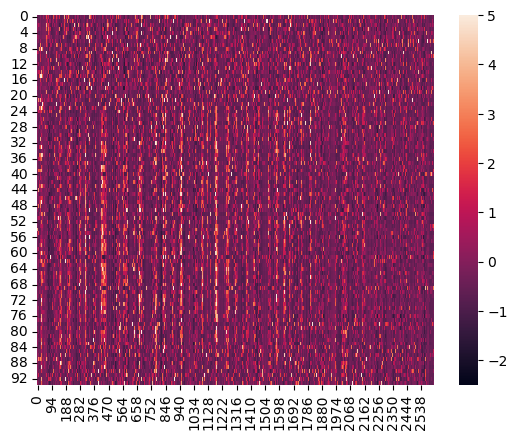

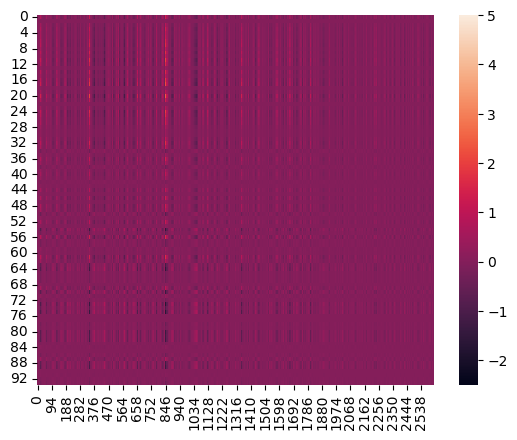

In [501]:
import seaborn as sns
sns.heatmap(voxels_activity_zscore, vmin=-2.5, vmax=5)
ind_oi = 2
plt.figure()
spat_comp3 = U[:,[ind_oi]] 
temp_comp3 = V[[ind_oi],:]
put_spatial_map = U[:,[ind_oi]] @ V[[ind_oi],:] * S[ind_oi]
sns.heatmap(put_spatial_map, vmin=-2.5, vmax=5)  # first component

<Axes: >

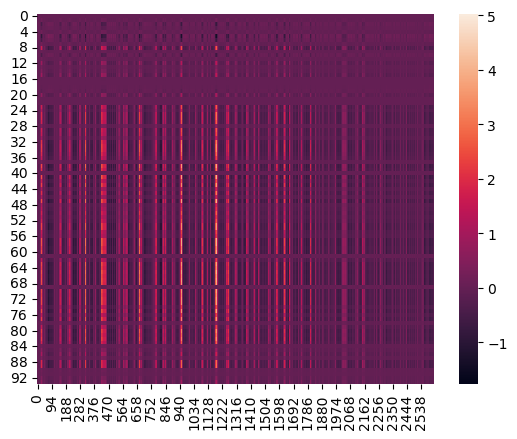

In [569]:
put_spatial_map0 = U[:,[0]] @ V[[0],:] * S[0]
sns.heatmap(put_spatial_map0)


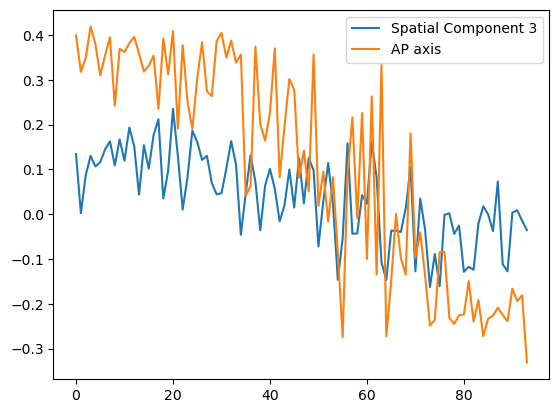

In [496]:
# plt.plot(U[:,0], label='Spatial Component 1')
# plt.plot(U[:,1], label='Spatial Component 2')
plt.plot(U[:,2], label='Spatial Component 3')

plt.plot(-1*voxel_rf_subset[:,0], label='AP axis')
plt.legend()
# plt.plot(voxel_rf_subset[:,1], label='DV axis')

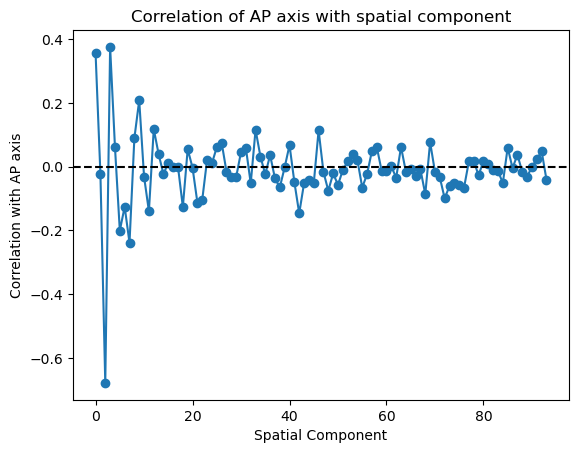

In [498]:
# plt.plot(U[:,0])
corrvals = []
for i in range(num_voxels_used):
    corrval = np.corrcoef(U[:,i], voxel_rf_subset[:,0])[0,1]
    corrvals.append(corrval)
plt.plot(corrvals, '-o')
plt.title('Correlation of AP axis with spatial component')
plt.xlabel('Spatial Component')
plt.ylabel('Correlation with AP axis')
plt.axhline(0, color='k', ls='--')

In [512]:
importlib.reload(utils)

<module 'utils' from '/Users/charliehuang/Documents/murthy_lab/projects/on_the_fly/utils.py'>

In [516]:
utils.interactive_plot(supervox_pos_aotu[voxel_subset,0], supervox_pos_aotu[voxel_subset,1], supervox_pos_aotu[voxel_subset,2], color_list=np.squeeze(spat_comp3), title='AOTU_R LC10a Supervoxels: colored by loading on SingVec3', cmap='Spectral_r', marker_size=10, vmin=-0.2, vmax=0.2)

(0.0, 100.0)

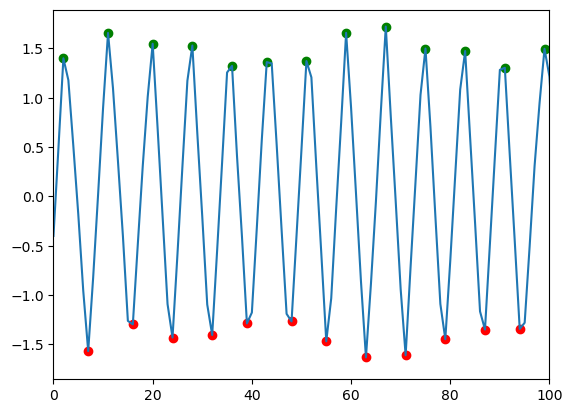

In [539]:
diffs_horiz =np.diff(exSideSide) 

# Find indices where vec[i-1] > 0 and vec[i] < 0
indices_pos_to_neg = np.where((diffs_horiz[1:] < 0) & (diffs_horiz[:-1] > 0))[0] + 1

# Find indices where vec[i-1] < 0 and vec[i] > 0
indices_neg_to_pos = np.where((diffs_horiz[1:] > 0) & (diffs_horiz[:-1] < 0))[0] + 1

plt.plot(exSideSide, label='sideSideZ')
plt.scatter(indices_pos_to_neg, exSideSide[indices_pos_to_neg], color='g', label='Pos to Neg')
plt.scatter(indices_neg_to_pos, exSideSide[indices_neg_to_pos], color='r', label='Neg to Pos')
plt.xlim([0,100])

In [570]:
backwindow = 5
forwindow = 10

trial_periods_posneg = [indices_pos_to_neg[i] for i in range(len(indices_pos_to_neg)) if indices_pos_to_neg[i] - backwindow > 0 and indices_pos_to_neg[i] + forwindow < len(exSideSide)]
trial_periods_negpos = [indices_neg_to_pos[i] for i in range(len(indices_neg_to_pos)) if indices_neg_to_pos[i] - backwindow > 0 and indices_neg_to_pos[i] + forwindow < len(exSideSide)]

print(len(trial_periods_posneg), len(trial_periods_negpos))

def create_cube(matrix, trial_indices, for_window, back_window, behavior_signal):
    trials = []
    print(f'{len(trial_indices)}: number of trials')
    behav_trials = []
    for ind in trial_indices:
        print(ind-back_window,ind+for_window)
        
        trials.append(matrix[:,ind-back_window:ind+for_window])
        behav_trials.append(behavior_signal[ind-back_window:ind+for_window])
    behav_trials = np.vstack(behav_trials)
    
    return np.dstack(trials), behav_trials

posneg_cube_vx, behav_posneg = create_cube(voxels_activity_zscore, trial_periods_posneg, forwindow, backwindow, exSideSide)
negpos_cube_vx, behav_negpos = create_cube(voxels_activity_zscore, trial_periods_negpos, forwindow, backwindow, exSideSide)

posneg_cube_spatmap,_ = create_cube(put_spatial_map, trial_periods_posneg, forwindow, backwindow, exSideSide)
negpos_cube_spatmap,_ = create_cube(put_spatial_map, trial_periods_negpos, forwindow, backwindow, exSideSide)

posneg_cube_spatmap0, _ = create_cube(put_spatial_map0, trial_periods_posneg, forwindow, backwindow, exSideSide)

317 317
317: number of trials
6 21
15 30
23 38
31 46
38 53
46 61
54 69
62 77
70 85
78 93
86 101
94 109
103 118
112 127
120 135
129 144
138 153
147 162
156 171
164 179
173 188
181 196
190 205
198 213
206 221
214 229
222 237
230 245
238 253
246 261
254 269
263 278
271 286
280 295
287 302
295 310
303 318
311 326
320 335
328 343
336 351
344 359
351 366
360 375
368 383
376 391
384 399
392 407
400 415
408 423
417 432
425 440
434 449
442 457
450 465
458 473
466 481
474 489
482 497
490 505
499 514
506 521
515 530
523 538
531 546
539 554
547 562
555 570
563 578
572 587
582 597
591 606
599 614
607 622
616 631
624 639
635 650
644 659
653 668
661 676
671 686
680 695
688 703
697 712
706 721
714 729
722 737
731 746
739 754
748 763
757 772
766 781
775 790
783 798
792 807
802 817
811 826
819 834
828 843
836 851
845 860
853 868
861 876
869 884
878 893
887 902
896 911
904 919
912 927
921 936
929 944
938 953
946 961
955 970
964 979
972 987
980 995
988 1003
996 1011
1004 1019
1012 1027
1020 1035
1029 1044

In [557]:
behav_posneg.shape

(317, 15)

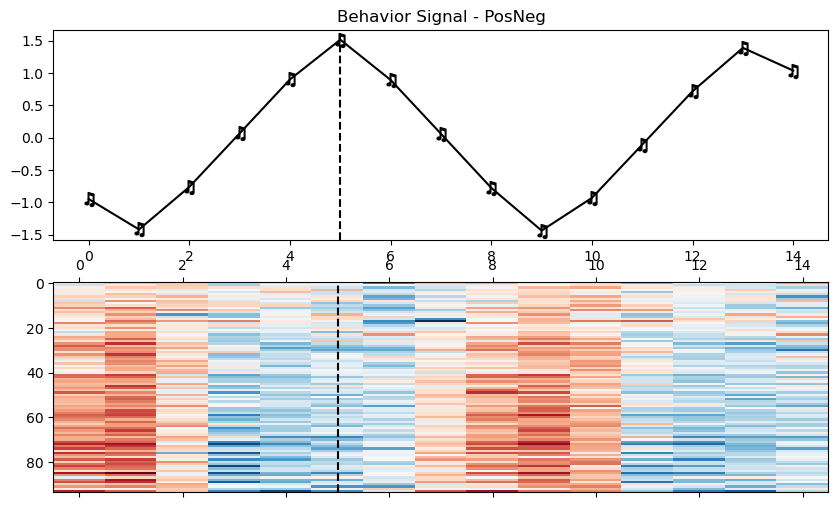

In [567]:
behav_posneg_mean = np.mean(behav_posneg, axis=0)
fig, ax = plt.subplots(2,1, figsize=(10, 6))
ax[0].plot(behav_posneg_mean, label='behav posneg mean', marker='$\u266B$', markersize=10, color='k')
ax[0].set_title('Behavior Signal - PosNeg')
ax[1].matshow(posneg_cube_vx.mean(axis=2), aspect='auto', cmap='RdBu')
ax[0].axvline(backwindow, color='k', ls='--')
ax[1].axvline(backwindow, color='k', ls='--')


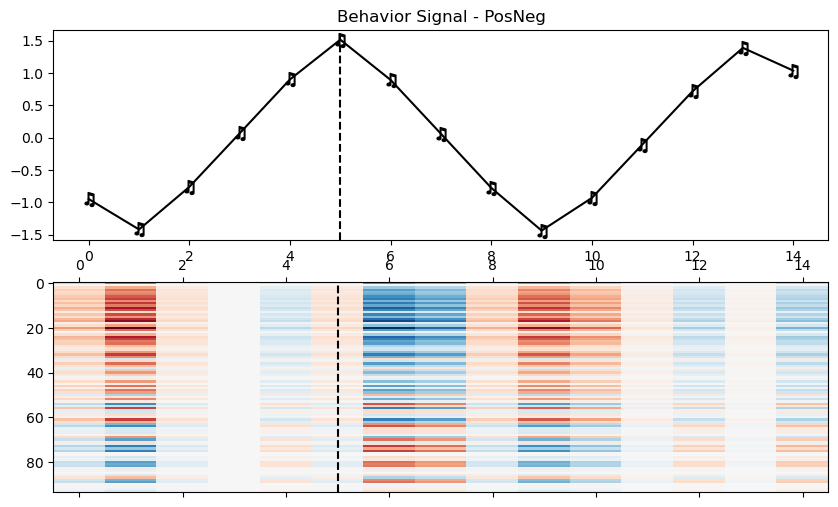

In [568]:
behav_posneg_mean = np.mean(behav_posneg, axis=0)
fig, ax = plt.subplots(2,1, figsize=(10, 6))
ax[0].plot(behav_posneg_mean, label='behav posneg mean', marker='$\u266B$', markersize=10, color='k')
ax[0].set_title('Behavior Signal - PosNeg')
ax[1].matshow(posneg_cube_spatmap.mean(axis=2), aspect='auto', cmap='RdBu')
ax[0].axvline(backwindow, color='k', ls='--')
ax[1].axvline(backwindow, color='k', ls='--')


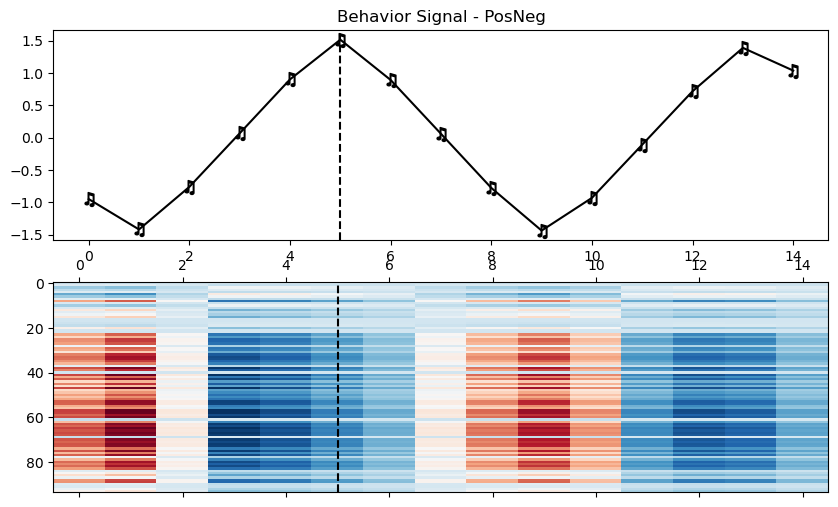

In [571]:
behav_posneg_mean = np.mean(behav_posneg, axis=0)
fig, ax = plt.subplots(2,1, figsize=(10, 6))
ax[0].plot(behav_posneg_mean, label='behav posneg mean', marker='$\u266B$', markersize=10, color='k')
ax[0].set_title('Behavior Signal - PosNeg')
ax[1].matshow(posneg_cube_spatmap0.mean(axis=2), aspect='auto', cmap='RdBu')
ax[0].axvline(backwindow, color='k', ls='--')
ax[1].axvline(backwindow, color='k', ls='--')


(200.0, 300.0)

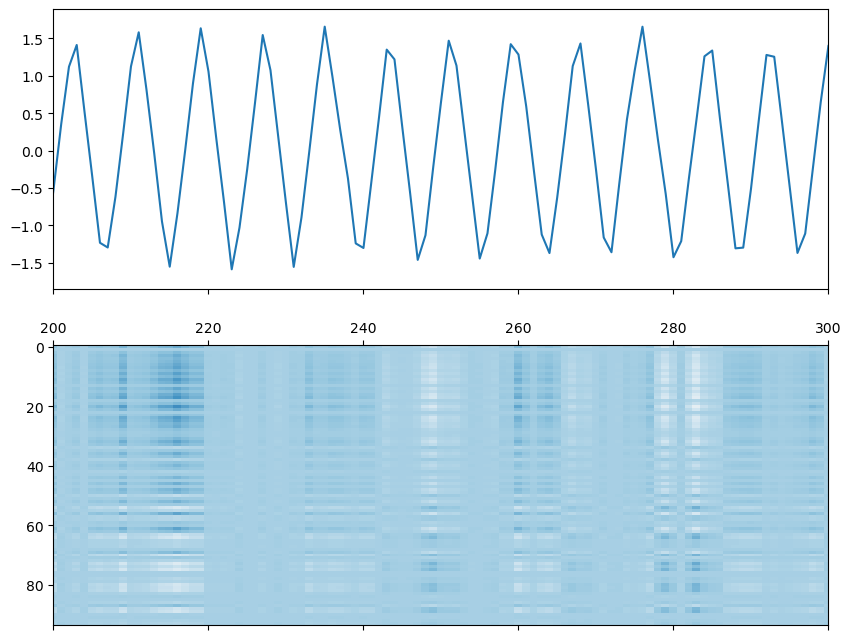

In [536]:
fig, ax = plt.subplots(2,1, figsize=(10, 8), sharex=True)
ax[0].plot(exSideSide)
ax[1].matshow(put_spatial_map, cmap='RdBu_r', vmin=-2.5, vmax=5, aspect='auto') 
ax[1].set_xlim([200,300])

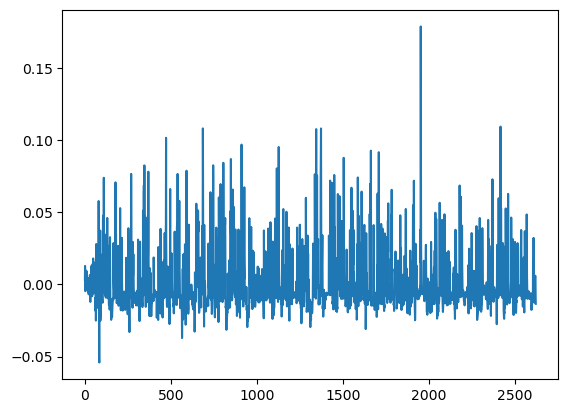

In [ ]:
put_spatial_map

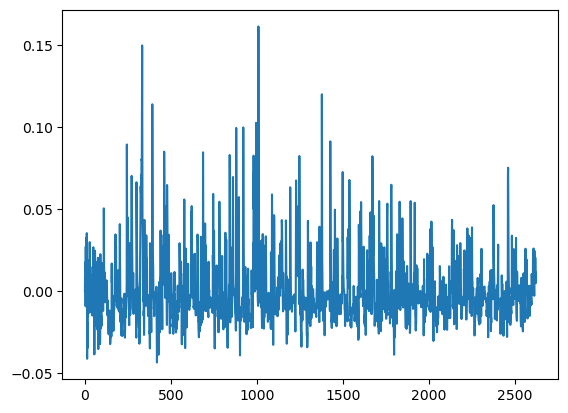

In [520]:
plt.plot(V[:,2])

In [468]:
for i in range(3):
    print((U[:,i] @ V[:,i].T).shape)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2623 is different from 94)

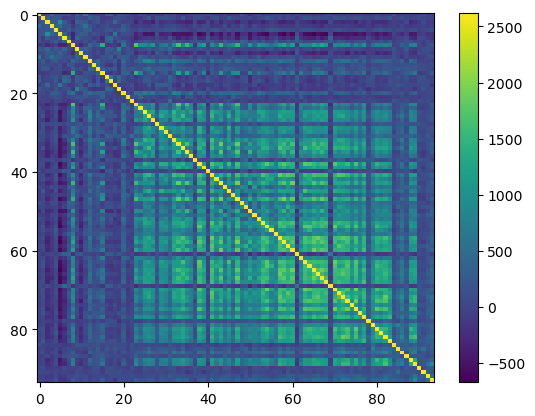

In [449]:
import scipy
covar_mat = (voxels_activity_zscore @ voxels_activity_zscore.T)
plt.imshow(covar_mat, aspect='auto', cmap='viridis')
plt.colorbar()

eigenvalues, vl, vr = scipy.linalg.eig(covar_mat, left=True)


In [455]:
vr.shape

(94, 94)

(0.0, 10.0)

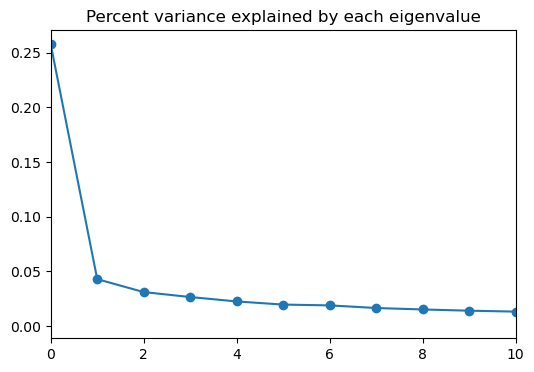

In [453]:
percent_var = eigenvalues.real/np.sum(eigenvalues.real)
plt.figure(figsize=(6,4))
plt.title("Percent variance explained by each eigenvalue")
plt.plot(percent_var, '-o')
plt.xlim([0,10])

In [ ]:
correlations_dict = defaultdict(list)
behavnames = ['sideSideZ', 'mfDistZ', 'mRSZ', 'mFSZ']
for behavname, signal in zip(behavnames, [exSideSide, exmfDistZ, exmFSZ, exmRSZ]):
    for voxel in voxels_activity_zscore:
        corrcoef = np.corrcoef(voxel, signal)[0,1]
        correlations_dict[behavname].append(corrcoef)

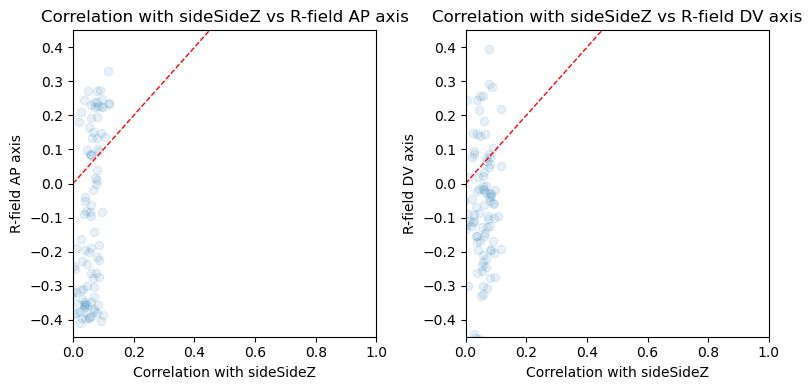

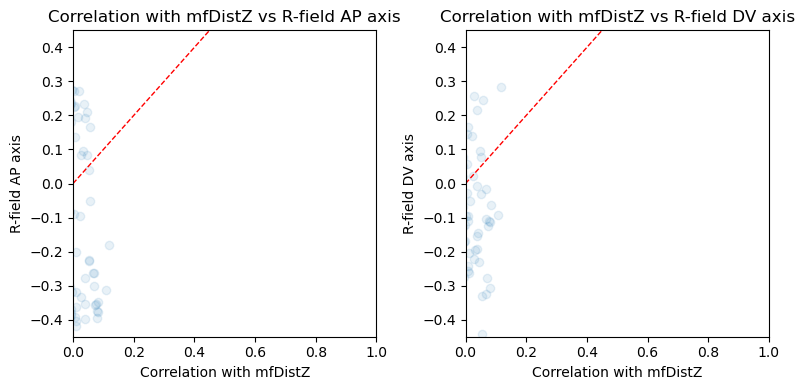

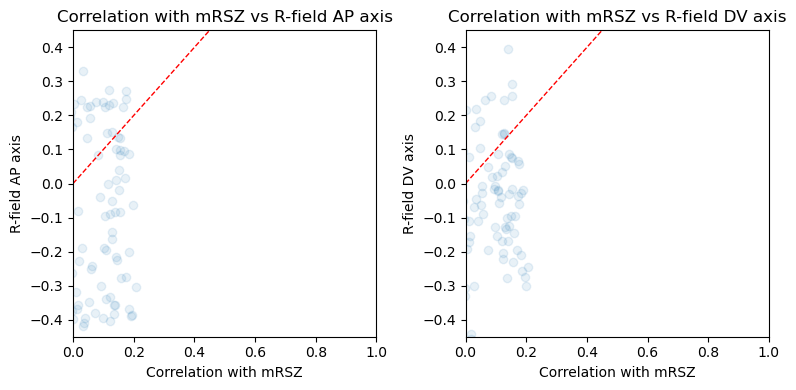

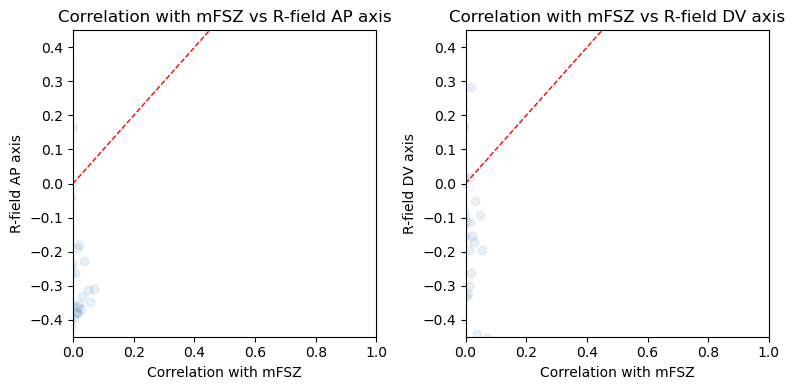

In [ ]:
for behavname, signal in zip(behavnames, [exSideSide, exmfDistZ, exmFSZ, exmRSZ]):
    fig, ax = plt.subplots(1,2, figsize=(8,4))
    ax[0].scatter(correlations_dict[behavname], voxel_rf_subset[:, 0], alpha=0.1)
    ax[0].set_xlabel(f'Correlation with {behavname}')
    ax[0].set_ylabel('R-field AP axis')
    ax[0].set_title(f'Correlation with {behavname} vs R-field AP axis') 
    ax[0].set_xlim([0,1])
    ax[0].set_ylim([-0.45,0.45])
    lims = [max(ax[0].get_xlim()[0], ax[0].get_ylim()[0]), min(ax[0].get_xlim()[1], ax[0].get_ylim()[1])]
    ax[0].plot(lims, lims, 'r--', lw=1)
    
    ax[1].scatter(correlations_dict[behavname], voxel_rf_subset[:, 1], alpha=0.1)
    ax[1].set_xlabel(f'Correlation with {behavname}')
    ax[1].set_ylabel('R-field DV axis')
    ax[1].set_title(f'Correlation with {behavname} vs R-field DV axis')
    ax[1].set_xlim([0,1])
    ax[1].set_ylim([-0.45,0.45])
    lims = [max(ax[1].get_xlim()[0], ax[1].get_ylim()[0]), min(ax[1].get_xlim()[1], ax[1].get_ylim()[1])]
    ax[1].plot(lims, lims, 'r--', lw=1)
    plt.tight_layout()
    plt.show()

(300.0, 500.0)

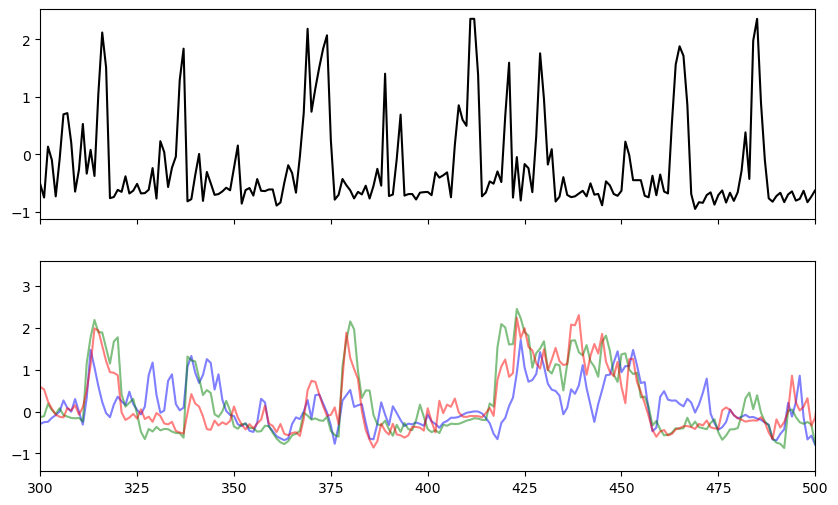

In [406]:
color_simple = np.arange(num_voxels_used)/num_voxels_used
posterior_mean = np.mean(voxels_activity_ap_sorted[:10], axis=0)
middle_mean = np.mean(voxels_activity_ap_sorted[40:50], axis=0)
anterior_mean = np.mean(voxels_activity_ap_sorted[-10:], axis=0)

fig, ax = plt.subplots(2,1, figsize=(10,6), sharex=True)
ax[0].plot(exmfDistZ, c='k')
ax[1].plot(posterior_mean, alpha=0.5, c='b')
ax[1].plot(middle_mean, alpha=0.5, c='g')
ax[1].plot(anterior_mean, alpha=0.5, c='r')
ax[1].set_xlim([300,500])

<Axes: title={'center': 'AOTU_R LC10a Supervoxels: colored by rfield DV axis'}>

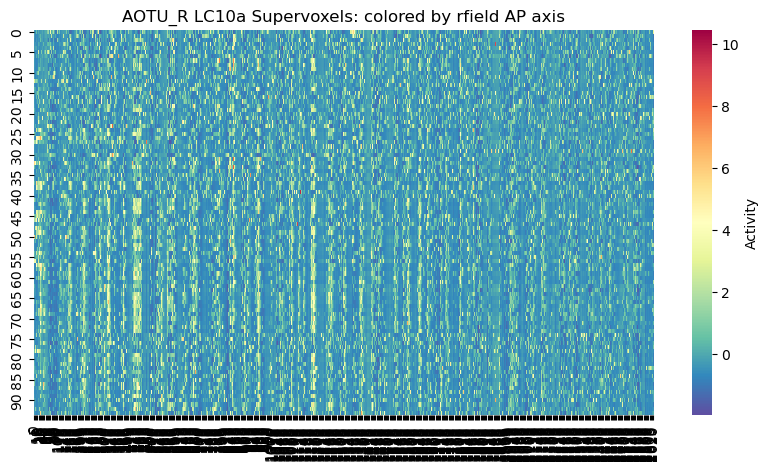

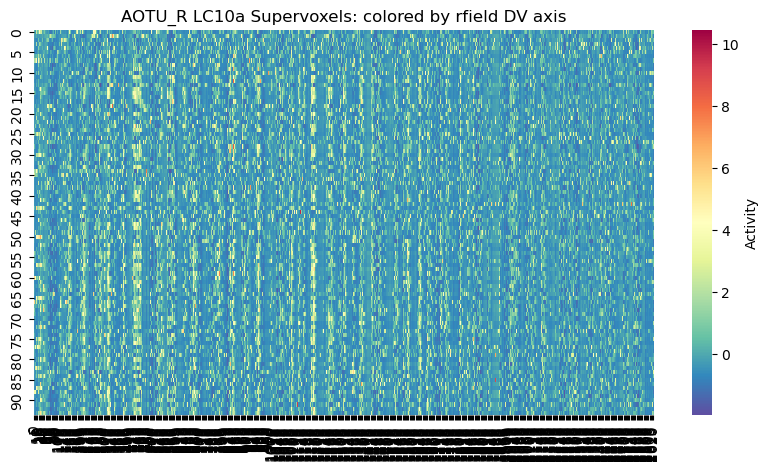

In [379]:
import seaborn as sns
plt.figure(figsize=(10, 5))
plt.title('AOTU_R LC10a Supervoxels: colored by rfield AP axis')
sns.heatmap(voxels_activity_ap_sorted, cmap='Spectral_r', cbar_kws={'label': 'Activity'}, xticklabels=5, yticklabels=5)
plt.figure(figsize=(10, 5))
plt.title('AOTU_R LC10a Supervoxels: colored by rfield DV axis')
sns.heatmap(voxels_activity_dv_sorted, cmap='Spectral_r', cbar_kws={'label': 'Activity'}, xticklabels=5, yticklabels=5)


In [360]:
ap_sort_inds

array([ 3, 20, 30,  0, 12,  7, 18, 32, 29, 26, 11,  4, 22, 37, 41,  9, 10,
       13, 49, 34,  6, 16, 31,  2, 33, 63, 15, 14,  1, 19,  5, 25, 44, 45,
       27, 28, 61, 23,  8, 17, 40, 59, 57, 38, 43, 24, 21, 69, 39, 47, 51,
       56, 53, 42, 46, 36, 48, 35, 50, 66, 58, 52, 71, 76, 75, 54, 70, 67,
       60, 62, 68, 72, 81, 65, 90, 92, 83, 91, 87, 80, 88, 79, 86, 77, 85,
       74, 89, 82, 78, 73, 84, 64, 55, 93])

# Monocular vs binocular

In [ ]:
# Load synpases
bino_left = np.load("bino_left.npy") * scale_factor
bino_right = np.load("bino_right.npy") * scale_factor

# Filter right
c, d = neuropilCenterDists["LO_R"]
keep = np.linalg.norm(bino_right - c, axis=1) < d
bino_right = bino_right[keep]

# Filter left
c, d = neuropilCenterDists["LO_L"]
keep = np.linalg.norm(bino_left - c, axis=1) < d
bino_left = bino_left[keep]

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

subset_keylist = lc10a_right_all['key_list_bouts'][inds_fda_aotu_r]
subset_boutons = lc10a_right_all['boutons'][inds_fda_aotu_r]
print(subset_boutons.shape)

subset_rf_centres = np.array([lc10a_rfields_right_dict[k] for k in subset_keylist])
normalize = lambda x: (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x))

colors_ap_axis= normalize(subset_rf_centres[:, 0])
colors_dv_axis = normalize(subset_rf_centres[:, 1])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*subset_boutons.T, c=colors_ap_axis, alpha=0.05, lw=0.1, cmap='RdBu')
# ax.scatter(*neuropilCenterDists['AOTU_R'][0], c='k', alpha=1.0)
plt.show()

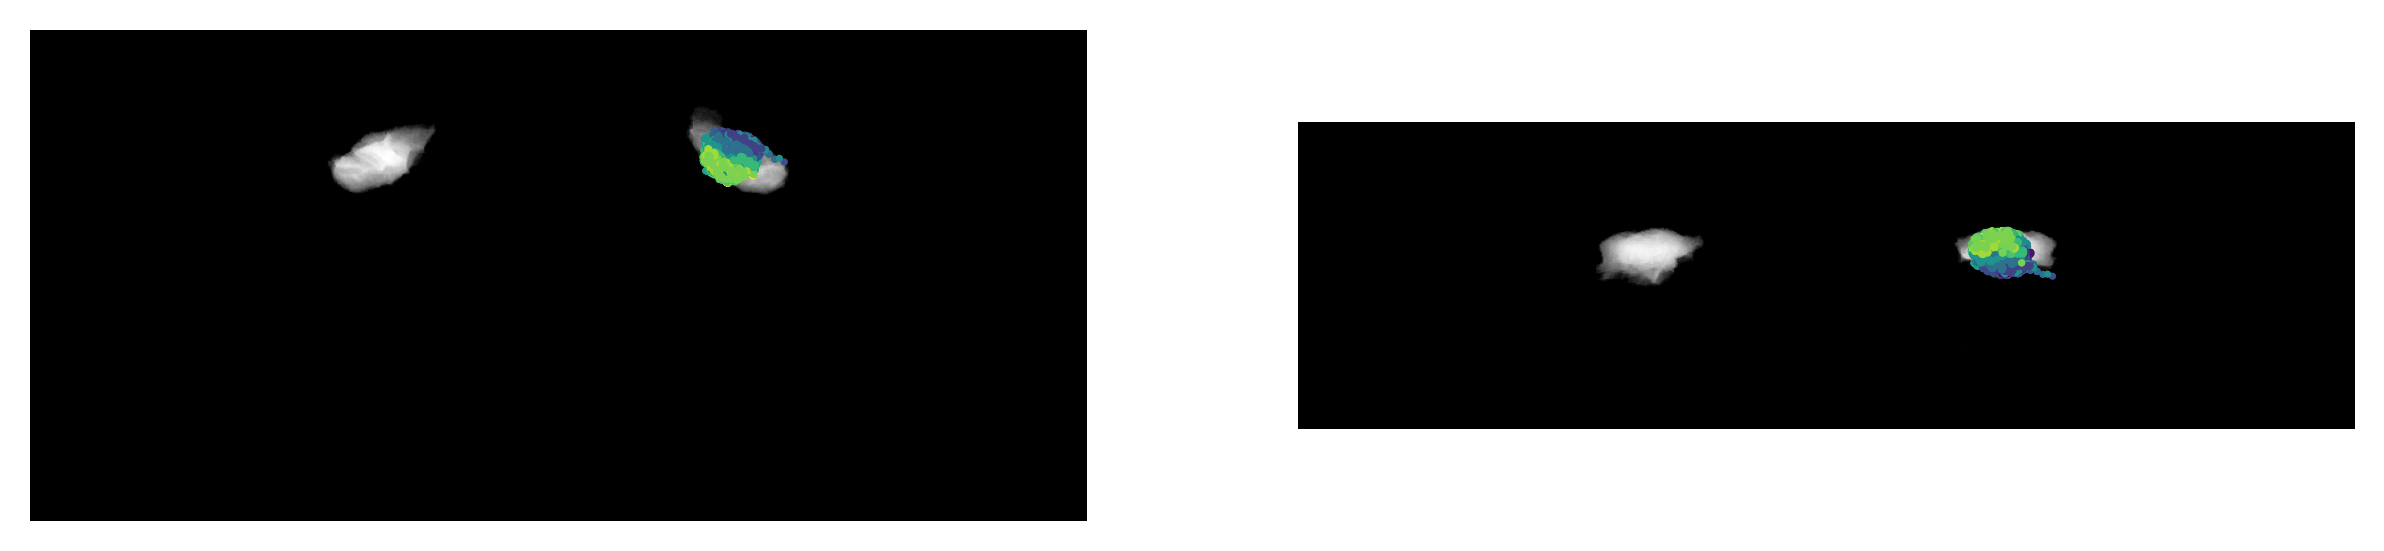

In [155]:
mask =  neuropilMasks["AOTU_R"] + neuropilMasks["AOTU_L"] #+ neuropilMasks["AOTU_L"] + neuropilMasks["AOTU_R"]
neuropil_projections = [np.rot90(mask.sum(axis=k))[::-1] for k in range(3)[::-1]]  # CORONAL, HORIZOTNAL, SAGITTAL
fig, axes = plt.subplots(1, 2, figsize=(10, 3), dpi=300)
for i, ax in enumerate(axes):
    ax.imshow(neuropil_projections[i], cmap="Grays_r")
    ax.axis("off")

axes[0].scatter(*subset_boutons[:, (0, 1)].T, c=colors_ap_axis, lw=0, s=3, cmap="viridis")
axes[1].scatter(*subset_boutons[:, (0, 2)].T, c=colors_ap_axis, lw=0, s=3, cmap="viridis")


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), dpi=300)
for i, ax in enumerate(axes):
    ax.imshow(neuropil_projections[i], cmap="Grays_r")
    ax.axis("off")

for syns in (bino_left, bino_right):

    zorder = np.argsort(syns[:, 2])[::-1]
    syns = syns[zorder]
    c = np.arange(len(syns))
    axes[0].scatter(*syns[:, (0, 1)].T, c=c, lw=0, s=3, cmap="viridis")

    yorder = np.argsort(syns[:, 1])[::-1]
    axes[1].scatter(*syns[yorder][:, (0, 2)].T, c=c[yorder], lw=0, s=3, cmap="viridis")

axes[0].set_title("Frontal view")
axes[1].set_title("Dorsal view")
plt.tight_layout()
# plt.savefig("lc14a1_pre_synapses_mapped.svg")

# Clean up data

In [ ]:
from sklearn.neighbors import KernelDensity

In [ ]:
kde_bino = KernelDensity(kernel="gaussian", bandwidth=30).fit(np.concatenate([bino_right, bino_left]))
thresh = -17

In [421]:
neuropilCenterDists['LO_L']

(array([405.52930314, 452.28414715, 340.08365059]), 200)

In [ ]:
data_clean = {}
for name, info in data.items():
    print(name)
    info_clean = {}
    info_clean.update(info)

    for neuropil, (xyz, timeseries) in info["imaging"].items():
        c, d = neuropilCenterDists[neuropil]
        dist_to_center = np.linalg.norm(xyz - c, axis=1)
        keep = dist_to_center < d
        xyz = xyz[keep]
        timeseries = timeseries[keep]
        dist_to_center = dist_to_center[keep]
        if neuropil in ("LO_R", "LO_L"):
            c = kde_bino.score_samples(xyz)
            is_bino = c > thresh
        else:
            c = np.zeros_like(dist_to_center)
            is_bino = np.zeros_like(dist_to_center).astype("bool")
        info_clean["imaging"][neuropil] = (xyz, timeseries, is_bino, c)
    data_clean[name] = info_clean

In [ ]:
all_svx = []
for name, info in data.items():
    for neuropil in ("LO_R", "LO_L"):
        xyz, *_, density = info["imaging"][neuropil]
        all_svx.append(np.hstack([xyz, density[:, None]]))
all_svx = np.concat(all_svx)


fig, axes = plt.subplots(1, 2, figsize=(10, 3), dpi=300)
for i, ax in enumerate(axes):
    ax.imshow(neuropil_projections[i], cmap="Grays")
    ax.axis("off")

zorder = np.argsort(all_svx[:, 2])[::-1]
all_svx = all_svx[zorder]
alpha = np.exp(all_svx[:, 3])
alpha -= alpha.min()
alpha /= alpha.max()
axes[0].scatter(*all_svx[:, (0, 1)].T, c=all_svx[:, 3], alpha=alpha, lw=0, s=1, cmap="plasma", vmin=thresh, vmax=-15.5)

yorder = np.argsort(all_svx[:, 1])[::-1]
axes[1].scatter(*all_svx[yorder][:, (0, 2)].T, c=all_svx[yorder, 3], alpha=alpha[yorder], lw=0, s=1, cmap="plasma", vmin=thresh, vmax=-15.5)

axes[0].set_title("Frontal view")
axes[1].set_title("Dorsal view")
plt.tight_layout()
# plt.savefig("binocular_supervoxels.svg")

# Compare activity centered

In [ ]:
svd_results = {}

for name, info in data_clean.items():

    # Concatenate data
    xyz_r, timeseries_r, is_bino_r, density_r = info["imaging"]["LO_R"]
    xyz_l, timeseries_l, is_bino_l, density_l = info["imaging"]["LO_L"]
    female_pos = info["sideSideZ"]

    # Create features
    timeseries = np.concatenate([timeseries_r, timeseries_l], axis=0)[:, :len(female_pos)]
    xyz = np.concatenate([xyz_r, xyz_l], axis=0)
    is_bino = np.concatenate([is_bino_r, is_bino_l], axis=0)
    is_side = np.zeros_like(is_bino).astype("i4")
    is_side[:len(is_bino_r)] = 1
    is_side[len(is_bino_r):] = -1
    density = np.concatenate([density_r, density_l], axis=0)

    # Filter ROIs
    corrs = np.array([np.correlate(t, female_pos[15:-15], mode="valid") for t in timeseries])
    mean_corr = np.abs(corrs).mean(axis=1)
    keep = mean_corr > np.percentile(mean_corr, 75)

    # Z-score timeseries
    timeseries = timeseries[keep]
    timeseries = (timeseries - np.mean(timeseries, axis=1, keepdims=True)) / np.std(timeseries, axis=1, keepdims=True)

    # Take features of correct ROIs
    xyz = xyz[keep]
    is_bino = is_bino[keep].astype("float64")
    is_bino[is_bino == 0] = -1
    is_side = is_side[keep]
    density = density[keep]

    is_bino = is_bino / np.linalg.norm(is_bino)
    is_side = is_side / np.linalg.norm(is_side)

    is_bino_random = is_bino[np.random.permutation(np.arange(len(is_bino)))]
    is_side_random = is_side[np.random.permutation(np.arange(len(is_side)))]

    # SVD
    U, S, Vt = np.linalg.svd(timeseries)
    n = 50
    U, S, Vt = U[:, :n], S[:n], Vt[:n]

    # Project onto binocular/side vectors
    bino_projection = np.dot(is_bino, U)
    side_projection = np.dot(is_side, U)
    bino_projection_random = np.dot(is_bino_random, U)
    side_projection_random = np.dot(is_side_random, U)

    svd_results[name] = dict(U=U, Vt=Vt, projections=np.column_stack([bino_projection, side_projection, bino_projection_random, side_projection_random]), labels=np.column_stack([is_bino, is_side, density]), xyz=xyz, female_pos=female_pos, t=timeseries)


In [ ]:
from scipy.signal import find_peaks

In [ ]:
# Example bino

example = list(svd_results.keys())[0]
svd = svd_results[example]

female_pos = svd["female_pos"]
U = svd["U"]
Vt = svd["Vt"]
projections = svd["projections"]
xyz = svd["xyz"]
labels = svd["labels"]
timeseries = svd["t"]

centered = np.zeros_like(female_pos) - 1
centered[np.abs(female_pos) < 0.2] = 1

v_projection = np.dot(Vt, centered / np.linalg.norm(centered))

signs = np.sign(np.dot(labels[:, 0], U))

best, = np.where((v_projection > 0.05) & (signs * projections[:, 0] > 0.4))
i = best[0]


fig, axes = plt.subplots(2, figsize=(5, 4), dpi=300)
for ax in axes:
    ax.imshow(neuropil_projections[0], cmap="Grays")
    ax.axis("off")

zorder = np.argsort(xyz[:, 2])[::-1]
axes[0].scatter(*xyz[zorder, :2].T, c=U[zorder, i], lw=0, s=3, cmap="bwr", vmin=-0.08, vmax=0.08)
axes[1].scatter(*xyz[zorder, :2].T, c=labels[zorder, 2], lw=0, s=3, cmap="plasma", vmin=thresh, vmax=-15.5)

axes[0].set_title("Vector weights")
axes[1].set_title("Binocularity")

plt.tight_layout()
plt.savefig("example_binocular_svxs.svg")

sorted_ids = np.argsort(U[:, i])[::-1][:50]
X = timeseries[sorted_ids]

peaks, *_ = find_peaks(female_pos)
starts = peaks[::2][:-1]
med = int(np.median(np.diff(starts)))

X_aligned = np.hstack([X[:, starts + dt].mean(axis=1, keepdims=True) for dt in range(med)])
stim = np.array([female_pos[starts + dt].mean() for dt in range(med)])

fig, axes = plt.subplots(2, figsize=(1, 4), dpi=300, sharex=True, gridspec_kw={'height_ratios': (0.5, 8), 'hspace': 0.05})
axes[0].plot([0, 2, 4, 6, 8, 10, 12, 14, 16], [1, 0, -1, 0, 1, 0, -1, 0, 1], c="k")
# axes[0].plot(stim)
im = axes[1].matshow(X_aligned, aspect="auto", cmap="inferno")
for ax in axes:
    ax.axis("off")
cax = fig.add_axes([0.95, 0.15, 0.1, 0.6])
cax = fig.colorbar(im, cax=cax)
cax.set_label("Mean z-scored dF/F")
plt.savefig("example_binocular_svxs_traces.svg")

In [ ]:
# Example left/right

i = 0

fig, ax = plt.subplots(figsize=(3, 4), dpi=300)
ax.imshow(neuropil_projections[0], cmap="Grays")
ax.axis("off")

zorder = np.argsort(xyz[:, 2])[::-1]
ax.scatter(*xyz[zorder, :2].T, c=U[zorder, i], lw=0, s=3, cmap="bwr", vmin=-0.08, vmax=0.08)

ax.set_title("Vector weights")

plt.tight_layout()
plt.savefig("example_left_right_svxs.svg")

sorted_ids = np.argsort(U[:, i])[::-1]
X = timeseries[sorted_ids]

peaks, *_ = find_peaks(female_pos)
starts = peaks[::2][:-1]
med = int(np.median(np.diff(starts)))

X_aligned = np.hstack([X[:, starts + dt].mean(axis=1, keepdims=True) for dt in range(med)])
stim = np.array([female_pos[starts + dt].mean() for dt in range(med)])

fig, axes = plt.subplots(2, figsize=(1, 4), dpi=300, sharex=True, gridspec_kw={'height_ratios': (0.5, 8), 'hspace': 0.05})
axes[0].plot([0, 2, 4, 6, 8, 10, 12, 14, 16], [1, 0, -1, 0, 1, 0, -1, 0, 1], c="k")
# axes[0].plot(stim)
im = axes[1].matshow(X_aligned, aspect="auto", cmap="inferno")
for ax in axes:
    ax.axis("off")
cax = fig.add_axes([0.95, 0.15, 0.1, 0.6])
cax = fig.colorbar(im, cax=cax)
cax.set_label("Mean z-scored dF/F")
plt.savefig("example_left_right_svxs_traces.svg")


In [ ]:
v_scores_bi = []
u_scores_bi = []
u_scores_bi_rand = []

for name, svd in svd_results.items():
    female_pos = svd["female_pos"]
    Vt = svd["Vt"]
    projections = svd["projections"]

    centered = np.zeros_like(female_pos) - 1
    centered[np.abs(female_pos) < 0.2] = 1

    v_projection = np.dot(Vt, centered / np.linalg.norm(centered))

    v_scores_bi.append(v_projection)
    u_scores_bi.append(projections[:, 0])
    u_scores_bi_rand.append(projections[:, 2])

v_scores_bi = np.concatenate(v_scores_bi)
u_scores_bi = np.concatenate(u_scores_bi)
u_scores_bi_rand = np.concatenate(u_scores_bi_rand)

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(4, 3), dpi=150)
axes[0].scatter(v_scores_bi, u_scores_bi, c="k", lw=0, s=10, alpha=0.8)
axes[1].scatter(v_scores_bi, u_scores_bi_rand, c="0.5", lw=0, s=10, alpha=0.8)

for ax in axes:
    ax.set_xlabel("Temporal correlation")
axes[0].set_ylabel("Spatial correlation")

axes[0].set_title("Real")
axes[1].set_title("Superxovel id shuffled")

fig.suptitle("Binocular correlation")
plt.tight_layout()

plt.savefig("binocular_correlations.svg")

In [ ]:
v_scores_lr = []
u_scores_lr = []
u_scores_lr_rand = []

for name, svd in svd_results.items():
    female_pos = svd["female_pos"]
    Vt = svd["Vt"]
    projections = svd["projections"]

    v_projection = np.dot(Vt, female_pos / np.linalg.norm(female_pos))

    v_scores_lr.append(v_projection)
    u_scores_lr.append(projections[:, 1])
    u_scores_lr_rand.append(projections[:, 3])

v_scores_lr = np.concatenate(v_scores_lr)
u_scores_lr = np.concatenate(u_scores_lr)
u_scores_lr_rand = np.concatenate(u_scores_lr_rand)

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(4, 3), dpi=150)
axes[0].scatter(v_scores_lr, u_scores_lr, c="k", lw=0, s=10, alpha=0.8)
axes[1].scatter(v_scores_lr, u_scores_lr_rand, c="0.5", lw=0, s=10, alpha=0.8)

for ax in axes:
    ax.set_xlabel("Temporal correlation")
axes[0].set_ylabel("Spatial correlation")

axes[0].set_title("Real")
axes[1].set_title("Superxovel id shuffled")

fig.suptitle("Left-right correlation")
plt.tight_layout()

plt.savefig("sided_correlations.svg")

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
ax.scatter(np.abs(u_scores_bi), np.abs(u_scores_lr), c="k", lw=0, s=10, alpha=0.5)
ax.set_xlabel("Binocular correlation")
ax.set_ylabel("Side-side correlation")
ax.plot([0.2, 0.2], [0, 0.8], c="salmon", zorder=0)
ax.plot([0, 0.8], [0.2, 0.2], c="salmon", zorder=0)
plt.savefig("bi_vs_side_correlations.svg")

In [ ]:
# All binocular components

xyzc = []

for name, svd in svd_results.items():

    female_pos = svd["female_pos"]
    U = svd["U"]
    Vt = svd["Vt"]
    projections = svd["projections"]
    xyz = svd["xyz"]
    labels = svd["labels"]

    signs = np.sign(np.dot(labels[:, 0], U))

    centered = np.zeros_like(female_pos) - 1
    centered[np.abs(female_pos) < 0.2] = 1

    # Find Vt that care about centering
    v_projection = np.dot(Vt, centered / np.linalg.norm(centered))

    best, = np.where((v_projection > 0.05) & (signs * projections[:, 0] > 0.1))
    if len(best):
        u_mean = (signs[best] * U[:, best]).mean(axis=1, keepdims=True)
        xyzc.append(np.hstack([xyz[:, :3], u_mean]))

xyzc = np.concatenate(xyzc, axis=0)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(5, 8), dpi=300)
for i, ax in enumerate(axes):
    ax.imshow(neuropil_projections[i], cmap="Grays")
    ax.axis("off")

zorder = np.argsort(xyzc[:, 2])[::-1]
axes[0].scatter(*xyzc[zorder, :2].T, c=xyzc[zorder, -1], lw=0, s=1, cmap="bwr", vmin=-0.05, vmax=0.05, alpha=0.5)

zorder = np.argsort(xyzc[:, 1])[::-1]
axes[1].scatter(*xyzc[zorder][:, (0, 2)].T, c=xyzc[zorder, -1], lw=0, s=1, cmap="bwr", vmin=-0.05, vmax=0.05, alpha=0.5)

plt.tight_layout()

In [ ]:
# Grab all binocular

all_bino = []
all_right = []
all_left = []

xyzc = []

for name, svd in svd_results.items():

    female_pos = svd["female_pos"]
    U = svd["U"]
    Vt = svd["Vt"]
    projections = svd["projections"]
    xyz = svd["xyz"]
    labels = svd["labels"]
    timeseries = svd["t"]
    labels = svd["labels"]

    signs = np.sign(np.dot(labels[:, 0], U))

    # Find most binocular
    best, = np.where((signs * projections[:, 0] > 0.2) & (np.abs(projections[:, 1]) < 0.2))

    if not len(best):
        continue

    X = timeseries
    peaks, *_ = find_peaks(female_pos)
    starts = peaks[:][:-1]
    med = int(np.median(np.diff(starts)))

    stim = np.array([female_pos[starts + dt].mean() for dt in range(med)])

    X_aligned = np.hstack([X[:, starts + dt].mean(axis=1, keepdims=True) for dt in range(med)])

    u_mean = (U[:, best] * signs[best]).mean(axis=1)
    order = np.argsort(u_mean)[::-1]
    X_aligned = X_aligned[order][:, :8]

    all_bino.append(X_aligned[:100])
    top = np.hstack([xyz[order][:100, :3], u_mean[order][:100, None]])
    bottom = np.hstack([xyz[order][-100:, :3], u_mean[order][-100:, None]])
    xyzc.append(np.concatenate((top, bottom), axis=0))

    side = np.sign(labels[:, 1])[order][-100:]
    all_right.append(X_aligned[-100:][side > 0])
    all_left.append(X_aligned[-100:][side < 0])


all_bino = np.concatenate(all_bino)
all_right = np.concatenate(all_right)
all_left = np.concatenate(all_left)

xyzc = np.concatenate(xyzc)


fig, ax = plt.subplots(figsize=(2, 2), dpi=150)
ax.plot(np.mean(all_bino, axis=0), c="r")
ax.plot(np.mean(all_right, axis=0), c="b")
ax.plot(np.mean(all_left, axis=0), c="b")
for spine in ("top", "right"):
    ax.spines[spine].set_visible(False)
ax.set_xticks([0, 7])
ax.set_xticklabels(["-\u03c0", "\u03c0"])
ax.set_xlabel("Female phase")
ax.set_ylabel("Mean z-scored dF/F")
plt.tight_layout()
plt.savefig("dFF_mean_right_center_left.svg")

fig, axes = plt.subplots(1, 2, figsize=(5, 8), dpi=300)
for i, ax in enumerate(axes):
    ax.imshow(neuropil_projections[i], cmap="Grays")
    ax.axis("off")

zorder = np.argsort(xyzc[:, 2])[::-1]
axes[0].scatter(*xyzc[zorder, :2].T, c=xyzc[zorder, -1], lw=0, s=1, cmap="bwr", vmin=-0.1, vmax=0.1, alpha=0.3)

zorder = np.argsort(xyzc[:, 1])[::-1]
axes[1].scatter(*xyzc[zorder][:, (0, 2)].T, c=xyzc[zorder, -1], lw=0, s=1, cmap="bwr", vmin=-0.1, vmax=0.1, alpha=0.3)

plt.tight_layout()
plt.savefig("right_center_left_supervoxels.svg")

In [ ]:
xyzc_l = []
xyzc_a = []

for name, svd in svd_results.items():

    projections = svd["projections"]
    labels = svd["labels"]
    U = svd["U"]
    Vt = svd["Vt"]
    female_pos = svd["female_pos"]
    xyz = svd["xyz"]

    signs = np.sign(np.dot(labels[:, 0], U))

    # Find most binocular
    best, = np.where((signs * projections[:, 0] > 0.2) & (np.abs(projections[:, 1]) < 0.2))

    if not len(best):
        continue

    # Lobula

    u_mean = (signs[best] * U[:, best]).mean(axis=1, keepdims=True)
    xyzc_l.append(np.hstack([xyz[:, :3], u_mean]))

    # AOTU

    xyz_r, aotu_r, *_ = data_clean[name]["imaging"]["AOTU_R"]
    xyz_l, aotu_l, *_ = data_clean[name]["imaging"]["AOTU_L"]

    aotu_r = aotu_r / np.linalg.norm(aotu_r, axis=1, keepdims=True)
    aotu_r = aotu_r[:, :len(female_pos)]

    aotu_l = aotu_l / np.linalg.norm(aotu_l, axis=1, keepdims=True)
    aotu_l = aotu_l[:, :len(female_pos)]

    aotu = np.concatenate((aotu_r, aotu_l), axis=0)
    aotu_xyz = np.concatenate((xyz_r, xyz_l), axis=0)

    v = (Vt[best] * signs[best, None])
    v = v / np.linalg.norm(v)
    proj = np.dot(aotu, v.T).mean(axis=1)

    xyzc_a.append(np.hstack([aotu_xyz, proj[:, None]]))

xyzc_l = np.concatenate(xyzc_l, axis=0)
xyzc_a = np.concatenate(xyzc_a, axis=0)

In [ ]:
mask =  neuropilMasks["LO_R"] + neuropilMasks["LO_L"] + neuropilMasks["AOTU_L"] + neuropilMasks["AOTU_R"]
all_neuropil_projections = [np.rot90(mask.sum(axis=k))[::-1] for k in range(3)[::-1]]  # CORONAL, HORIZOTNAL, SAGITTAL

In [ ]:
fig, rows = plt.subplots(2, 2, figsize=(8, 5), dpi=300)

for (xyzc, axes) in zip((xyzc_l, xyzc_a), rows):
    for i, ax in enumerate(axes):
        ax.imshow(all_neuropil_projections[i], cmap="Grays")
        ax.axis("off")

    zorder = np.argsort(xyzc[:, 2])[::-1]
    axes[0].scatter(*xyzc[zorder, :2].T, c=xyzc[zorder, -1], lw=0, s=1, cmap="RdBu_r", vmin=-0.1, vmax=0.1, alpha=0.5)

    zorder = np.argsort(xyzc[:, 1])[::-1]
    axes[1].scatter(*xyzc[zorder][:, (0, 2)].T, c=xyzc[zorder, -1], lw=0, s=1, cmap="RdBu_r", vmin=-0.1, vmax=0.1, alpha=0.5)

plt.tight_layout()

plt.savefig("aotu+lobula_maps.svg")


In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
v_scores = []
u_scores = []
u_scores_rand = []

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
# ax0 = fig.add_subplot(121, projection="3d")
# ax1 = fig.add_subplot(122, projection="3d")

for name, svd in svd_results.items():

    # if name != "20240620_201":
    #     continue

    female_pos = svd["female_pos"] #- svd["female_pos"].mean()
    U = svd["U"]
    Vt = svd["Vt"]
    projections = svd["projections"]
    xyz = svd["xyz"]
    labels = svd["labels"]

    v_corr = np.array([np.correlate(v, female_pos[7:-7], mode="valid") for v in Vt])
    v_corr_max = np.max(v_corr, axis=1)
    # shift = np.argmax(v_corr, axis=1)

    # shifted = np.array([female_pos[shift::7].mean() for shift in range(7)])
    # offset = np.argmax(shifted)

    centered = np.zeros_like(female_pos) - 1
    centered[np.abs(female_pos) < 0.2] = 1
    # centered[female_pos > 0.5] = 1

    # Find Vt that care about centering
    v_projection = np.dot(Vt, centered / np.linalg.norm(centered))

    best = np.argsort(v_projection)[::-1]#[:3]

    v_scores.append(v_projection[best])
    u_scores.append(projections[best, 0])
    u_scores_rand.append(projections[best, 2])


    # show, = np.where((v_projection > 0.08) & (projections[:, 0] > 0.1))
    show, = np.where(neuropil_projections[:, 0] > 0.4)
    for i in show:
        # print(name, i)
        # ax0.scatter(*xyz.T, c=U[:, i], lw=0, s=5, vmin=-0.1, vmax=0.1, cmap="bwr", alpha=0.5)
    # ax1.scatter(*xyz.T, c=labels[:, 1], lw=0, s=1, vmin=-0.1, vmax=0.1, cmap="bwr", alpha=0.5)

        # CORRELATE TO AOTU
        aotu_r_xyz, aotu_r_t, *_ = data_clean[name]["imaging"]["AOTU_R"]
        aotu_l_xyz, aotu_l_t, *_ = data_clean[name]["imaging"]["AOTU_L"]

        aotu_r_t = aotu_r_t / np.linalg.norm(aotu_r_t, axis=1, keepdims=True)
        aotu_l_t = aotu_l_t / np.linalg.norm(aotu_l_t, axis=1, keepdims=True)

        cr = np.dot(aotu_r_t[:, :Vt.shape[1]], Vt[i])
        cl = np.dot(aotu_l_t[:, :Vt.shape[1]], Vt[i])

        ax.scatter(*aotu_r_xyz[:, (0, 1, 2)].T, c=cr, lw=0, alpha=0.5, s=5, vmin=-0.1, vmax=0.1, cmap="bwr")
        ax.scatter(*aotu_l_xyz[:, (0, 1, 2)].T, c=cl, lw=0, alpha=0.5, s=5, vmin=-0.1, vmax=0.1, cmap="bwr")
        # plt.scatter(aotu_xyz[:, 1], c, lw=0, alpha=0.5, s=5)
        # plt.show()


    # plt.scatter(*xyz[:, (0, 1)].T, c=U[:, best], lw=0, s=5, vmin=-0.1, vmax=0.1, cmap="bwr", alpha=0.5)
    # axes[0].scatter(v_projection[best], projections[best, 0], c="k", lw=0, s=10, alpha=0.5)
    # axes[1].scatter(v_projection[best], projections[best, 1], c="r", lw=0, s=10, alpha=0.5)

    # plt.hist(v_projection, alpha=0.5, bins=np.arange(-0.03, 0.035, 0.002))


    # plt.scatter(projections[:, 0], projections[:, 1], lw=0, c=v_projection, s=10, alpha=0.5, cmap="bwr", vmin=-1, vmax=1)
    # plt.scatter((projections[:, 1]), v_projection, lw=0, c="r", s=10, alpha=0.5)


    # Vt = np.roll(Vt, offset, axis=1)



    # aligned = np.roll(female_pos, -offset)
    # shifted = np.array([aligned[shift::7].mean() for shift in range(7)])
    # plt.plot(shifted)

    # break
    # for shift in range(15)
    #     plt.plot(female_pos[])
    # break

    # for corr in v_corr:
    #     plt.plot(corr, lw=0.1, c="k")
    # best = np.argsort(v_corr.max(axis=1))[::-1][0]
    # plt.matshow(v_corr[np.argsort(shift)])

    # centered = np.zeros_like(female_pos)
    # centered[np.abs(female_pos) < 0.2] = 1

    # v_projected = np.dot(Vt, centered)
    # best = np.argmax(v_projected)

    # good_i, = np.where((projections[:, 0] > 0.2) & (np.abs(projections[:, 1]) < 0.4))
    # for i in good_i:
    #     axes[0].scatter(*xyz[:, (0, 1)].T, c=U[:, i], lw=0, s=5, vmin=-0.1, vmax=0.1, cmap="bwr", alpha=0.5)
    #
    # axes[1].scatter(*xyz[:, (0, 1)].T, c=labels[:, 0], lw=0, s=5, vmin=-0.1, vmax=0.1, cmap="bwr", alpha=0.5)
    # plt.scatter(np.abs(projections[:, 0]), np.abs(projections[:, 1]), c=np.abs(projections[:, 0]) == np.max(np.abs(projections)[:, :2], axis=1))

    # plt.scatter(*xyz[:, (0, 2)].T, c=U[:, best], lw=0, s=5, vmin=-0.1, vmax=0.1, cmap="bwr")
    # plt.scatter((projections[:, 0]), v_corr_max, lw=0, c="r", s=10, alpha=0.5)
    # plt.scatter((projections[:, 1]), v_corr_max, lw=0, c="k", s=10, alpha=0.5)

    # break



v_scores = np.concatenate(v_scores)
u_scores = np.concatenate(u_scores)
u_scores_rand = np.concatenate(u_scores_rand)
reg = LinearRegression(fit_intercept=False).fit(v_scores.reshape(-1, 1), np.column_stack([u_scores, u_scores_rand]))
print(reg.coef_)

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
axes[0].scatter(v_scores, u_scores, c="k", lw=0, s=10, alpha=0.5)
axes[0].plot([0, 0.2], [0, 0.2 * 0.4])

axes[1].scatter(v_scores, u_scores_rand, c="r", lw=0, s=10, alpha=0.5)
axes[1].plot([0, 0.2], [0, 0.2 * reg.coef_[1, 0]])

In [ ]:
from scipy.stats import pearsonr

In [ ]:
pearsonr(v_scores, u_scores)

In [ ]:
# Average over trials
cycle_duration = 15
# kernel = np.hstack([np.linspace(0, 1, 8)[::-1], np.linspace(0, 1, 8)[1:]])
# kernel = kernel / kernel.sum()

# fig, axes = plt.subplots(3, figsize=(3, 12), dpi=300)

trial_averaged = defaultdict(list)
for name, info in data.items():
    side = info["side"]
    side = side - side.mean()
    side = side / np.abs(side).max()
    # Find trials
    diff = np.sign(np.diff(side[:500]))
    starts, = np.where(np.diff(diff) < 0)
    starts += 1
    # Average over trials
    aligned = {}
    for neuropil, (xyz, tseries) in info["imaging"].items():
        # print(neuropil)
        trials = []
        for t in starts:
            trial = tseries[:, t:t+15]
            if trial.shape[1] == 15:
                trials.append(trial)
        trials = np.mean(trials, axis=0)
        trial_averaged[neuropil].append(trials)
for k in trial_averaged.keys():
    trial_averaged[k] = np.concatenate(trial_averaged[k])
        # print(trials.shape)
        # conv = convolve(np.hstack([trials, trials[:, :-1]]), kernel[None], mode="valid")
        # tmax = np.argmax(conv, axis=1)
        # # fig, ax = plt.subplots(figsize=(5, 4))
        # # ax.matshow(trials[np.argsort(tmax)], aspect="auto")
        # axes[0].scatter(*xyz[:, (0, 1)].T, c=tmax, lw=0, s=1, alpha=0.2, cmap="hsv")
        # axes[1].scatter(*xyz[:, (0, 2)].T, c=tmax, lw=0, s=1, alpha=0.2, cmap="hsv")
        # axes[2].scatter(*xyz[:, (1, 2)].T, c=tmax, lw=0, s=1, alpha=0.2, cmap="hsv")
    # break
# for ax in axes:
#     ax.axis("equal")

In [ ]:
traces = trial_averaged["LO_L"]

In [ ]:
fig, ax = plt.subplots()
max_activity = np.max(traces, axis=1)
ax.matshow(traces[np.argsort(max_activity)], aspect="auto")

In [ ]:
best_traces = traces[max_activity > np.percentile(max_activity, 85)]

In [ ]:
plt.plot(best_traces.mean(axis=0))

In [ ]:
# Population events: when average activity in a neuropil exceeds threshold=0.5

all_population_events = []

for name, info in data.items():

    # if name != "20240620_201":
    #     continue

    aotu_xyz_r, aotu_traces_r = info["imaging"]["AOTU_R"]
    aotu_xyz_l, aotu_traces_l = info["imaging"]["AOTU_L"]

    lo_xyz_r, lo_traces_r = info["imaging"]["LO_R"]
    lo_xyz_l, lo_traces_l = info["imaging"]["LO_L"]

    population_events, = np.where((np.mean(aotu_traces_r, axis=0) > 0.5) | (np.mean(aotu_traces_l, axis=0) > 0.5) | (np.mean(lo_traces_r, axis=0) > 0.5) | (np.mean(lo_traces_l, axis=0) > 0.5))
    events = np.split(population_events, np.where(np.diff(population_events) > 1)[0] + 1)
    events = filter(lambda x: len(x) >= 3, events)

    for event in events:

        lo_r = lo_traces_r[:, event].mean(axis=1)
        lo_l = lo_traces_l[:, event].mean(axis=1)

        aotu_r = aotu_traces_r[:, event].mean(axis=1)
        aotu_l = aotu_traces_l[:, event].mean(axis=1)

        lo_r -= lo_r.min()
        lo_l -= lo_l.min()
        aotu_r -= aotu_r.min()
        aotu_l -= aotu_l.min()

        lo_r = np.square(lo_r)
        lo_l = np.square(lo_l)
        aotu_r = np.square(aotu_r)
        aotu_l = np.square(aotu_l)

        lo_r_c = np.dot(lo_r / lo_r.sum(), lo_xyz_r)
        lo_l_c = np.dot(lo_l / lo_l.sum(), lo_xyz_l)
        aotu_r_c = np.dot(aotu_r / aotu_r.sum(), aotu_xyz_r)
        aotu_l_c = np.dot(aotu_l / aotu_l.sum(), aotu_xyz_l)

        all_population_events.append([name, event[0], event[-1] + 1, lo_r_c, lo_l_c, aotu_r_c, aotu_l_c])



        # fig, axes = plt.subplots(1, 4)
        # axes[0].matshow(lo_traces_r[:, event[0]-10:event[-1]+10][np.argsort(lo_xyz_r[:, 2])], aspect="auto")
        # axes[1].matshow(lo_traces_l[:, event[0]-10:event[-1]+10][np.argsort(lo_xyz_l[:, 2])], aspect="auto")
        # axes[2].matshow(aotu_traces_r[:, event[0]-10:event[-1]+10][np.argsort(aotu_xyz_r[:, 2])], aspect="auto")
        # axes[3].matshow(aotu_traces_l[:, event[0]-10:event[-1]+10][np.argsort(aotu_xyz_l[:, 2])], aspect="auto")
        # break
    # break


    #     plt.scatter([lo_r_c[0]], [lo_r_c[2]])
    #     plt.scatter([lo_l_c[0]], [lo_l_c[2]])
    #     plt.scatter([aotu_r_c[0]], [aotu_r_c[2]])
    #     plt.scatter([aotu_l_c[0]], [aotu_l_c[2]])
    #
    # break

    # ax = plt.gca()
    # ax.set_xlim(200, 1400)
    # ax.set_ylim(0, 600)
        # break

        # fig, ax = plt.subplots()
        #
        # ax.scatter(*lo_xyz_r[np.argsort(lo_r)][:, (0, 2)].T, c=lo_r[np.argsort(lo_r)], lw=0, s=10, alpha=0.5)
        # ax.scatter(*lo_xyz_l[np.argsort(lo_l)][:, (0, 2)].T, c=lo_l[np.argsort(lo_l)], lw=0, s=10, alpha=0.5)
        #
        # ax.scatter(*aotu_xyz_r[np.argsort(aotu_r)][:, (0, 2)].T, c=aotu_r[np.argsort(aotu_r)], lw=0, s=10, alpha=0.5)
        # ax.scatter(*aotu_xyz_l[np.argsort(aotu_l)][:, (0, 2)].T, c=aotu_l[np.argsort(aotu_l)], lw=0, s=10, alpha=0.5)
        #
        # # ax.axis("equal")
        # ax.set_xlim(200, 1400)
        # ax.set_ylim(0, 600)

    # break

In [ ]:
name = "20240620_201"

fig, axes = plt.subplots(2, 4, figsize=(10, 6), dpi=300, sharex="col")
for i, neuropil in enumerate(["LO_R", "AOTU_R", "LO_L", "AOTU_L"]):
    xyz, traces = data[name]["imaging"][neuropil]
    axes[0, i].matshow(traces, vmin=-3, vmax=10, aspect="auto")
    axes[0, i].set_title(neuropil)
    axes[1, i].plot(traces.mean(axis=0), lw=0.5, c="k")
    axes[1, i].set_ylim(-1, 3)
for ax in axes.ravel():
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
axes[1, 0].set_yticks(np.arange(-1, 4))
axes[1, 0].set_ylabel("Neuropil mean activity (z-scored)")
axes[0, 0].set_ylabel("ROI")

trial_events = list(filter(lambda x: x[0] == name, all_population_events))
starts = [event[1] for event in trial_events]

for ax in axes[1]:
    ax.scatter(starts, np.ones(len(starts)) * 2.8, lw=0, s=3, c="k", marker="v")
    ax.plot([0, traces.shape[1] - 1], [0.5, 0.5], lw=1, c="w", zorder=0)

plt.tight_layout()
# plt.savefig("population_events.jpg")

for ax in axes[1]:
    ax.set_xlim(0, 500)
plt.savefig("population_events_zoom.jpg")

In [ ]:
mask = neuropilMasks["AOTU_R"] + neuropilMasks["LO_R"] + neuropilMasks["AOTU_L"] + neuropilMasks["LO_L"]
projections = [np.rot90(mask.sum(axis=k))[::-1] for k in range(3)]

In [ ]:
fig, rows = plt.subplots(4, 3, figsize=(15, 12), dpi=300)
for i, (name, start, end, *_) in enumerate(trial_events[:4]):
    axes = rows[i]
    for k in range(3):
        axes[2 - k].imshow(projections[k], cmap="Grays_r", aspect="auto")
    for j, neuropil in enumerate(["LO_R", "AOTU_R", "LO_L", "AOTU_L"]):
        xyz, traces = data[name]["imaging"][neuropil]
        mean = traces[:, start:end].mean(axis=1)
        for k in range(3):
            z = np.argsort(xyz[:, k])
            ij = [0, 1, 2]
            ij.pop(k)
            axes[2 - k].scatter(*xyz[z][:, tuple(ij)].T, c=mean[z], lw=0, s=8, alpha=0.5, cmap="inferno")
    for ax in axes:
        ax.grid("off")
        ax.set_xticks([])
        ax.set_yticks([])
plt.tight_layout()
plt.savefig("example_activity_mapped.jpg")

In [ ]:
xyz = np.array([event[3:] for event in all_population_events])
xyz.shape

In [ ]:
fig, rows = plt.subplots(4, 3, figsize=(15, 12), dpi=300, gridspec_kw={"width_ratios": [2, 2, 1]})

for i, neuropil in enumerate(["LO_R", "LO_L", "AOTU_R", "AOTU_L"]):
    axes = rows[i]
    for j, ax in enumerate(axes):
        im = np.rot90(neuropilMasks[neuropil].sum(axis=j))[::-1]
        axes[j].imshow(im, cmap="viridis", aspect="auto")
        k = [0, 1, 2]
        k.pop(j)
        axes[j].scatter(*xyz[:, i, tuple(k)].T, lw=0, s=5, c="w", alpha=0.5)

    for ax in axes:
        ax.grid("off")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect("equal")
for ax in rows[0, 1:]:
    ax.set_xlim(1000, 1500)
for ax in rows[1, 1:]:
    ax.set_xlim(200, 700)
for ax in rows[2, 1:]:
    ax.set_xlim(1000, 1500)
for ax in rows[3, 1:]:
    ax.set_xlim(200, 700)

plt.tight_layout()
plt.savefig("event_centroids.jpg")

In [ ]:
U, S, Vt = np.linalg.svd(neuropilSparse["LO_R"][::100])

In [ ]:
projected = xyz[:, 0] @ Vt

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# ax.scatter(*projected.T, alpha=0.5, lw=0, s=10)

ax.scatter(*xyz[:, 0].T, c=projected[:, 0], alpha=0.5, lw=0)
# ax.scatter(*xyz[:, 2].T, c=projected[:, 2], alpha=0.5, lw=0, s=10)

# for p, q in zip(xyz[:, 0], xyz[:, 2]):
#     ax.plot([p[0], q[0]], [p[1], q[1]], [p[2], q[2]], c="k", lw=0.1, alpha=0.5)

# ax.scatter(*xyz[:, 1].T, c=xyz[:, 1, 0])
# ax.scatter(*xyz[:, 3].T, c=xyz[:, 1, 0])
# for p, q in zip(xyz[:, 1], xyz[:, 3]):
#     ax.plot([p[0], q[0]], [p[1], q[1]], [p[2], q[2]], c="k", lw=0.1, alpha=0.5)

# ax.view_init(40, -30, 0)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), dpi=300)

axes[0].scatter(*xyz[:, 1, (0, 1)].T, c=projected[:, 0], s=8, alpha=0.5, lw=0)
axes[0].scatter(*xyz[:, 3, (0, 1)].T, c=projected[:, 0], s=8, alpha=0.5, lw=0)

axes[1].scatter(*xyz[:, 0, (0, 1)].T, c=projected[:, 0], s=8, alpha=0.5, lw=0)
axes[1].scatter(*xyz[:, 2, (0, 1)].T, c=projected[:, 0], s=8, alpha=0.5, lw=0)

plt.tight_layout()
plt.savefig("event_centroids_paired.jpg")

# for p, q in zip(xyz[:, 1, (0, 1)], xyz[:, 3, (0, 1)]):
#     axes[0].plot([p[0], q[0]], [p[1], q[1]], c="k", lw=0.1, alpha=0.5)
# for p, q in zip(xyz[:, 0, (0, 1)], xyz[:, 2, (0, 1)]):
#     axes[1].plot([p[0], q[0]], [p[1], q[1]], c="k", lw=0.1, alpha=0.5)
# plt.savefig("event_centroids_paired_connected.jpg")

In [ ]:
plt.scatter(xyz[:, 0, 0], xyz[:, 1, 0], lw=0, s=10)
# plt.gca().set_xlim(150, 300)
# plt.gca().set_ylim(150, 300)
plt.gca().axis("equal")

In [ ]:
fig, ax = plt.subplots()
ax.imshow(np.rot90((neuropilMasks["AOTU_R"] + neuropilMasks["LO_R"]).sum(axis=1))[::-1], origin="upper")
# fig = plt.figure()
# ax = fig.add_subplot(111, projection="3d")
ax.scatter(*aotu_xyz_r[:, (0, 2)].T, lw=0, s=1, c="w")
ax.scatter(*lo_xyz_r[:, (0, 2)].T, lw=0, s=1, c="w")
ax.scatter(*xyz[:, 0, (0, 2)].T, lw=0, s=10)
ax.set_xlim(1000, 1400)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
for i, ax in enumerate(axes):
    ax.imshow(np.rot90(neuropilMasks["LO_R"].sum(axis=i))[::-1], origin="upper")
    j = [0, 1, 2]
    j.pop(i)
    ax.scatter(*xyz[:, 0, tuple(j)].T, lw=0, s=10)
for ax in axes[1:]:
    ax.set_xlim(1000, 1400)
axes[0].set_ylim(500, 200)

In [ ]:
fig, ax = plt.subplots()
# lo = xyz[:, 0, (0, 2)]
# aotu = xyz[:, 1, (0, 2)]
for lo, aotu in zip(xyz[:, 1, (0, 1)], xyz[:, 3, (0, 1)]):
    ax.plot([lo[0], aotu[0]], [lo[1], aotu[1]], lw=0.1, c="k")

In [ ]:
fig, ax = plt.subplots()
ax.scatter(*xyz[:, 3, (1, 2)].T, c=xyz[:, 0, 0])

In [ ]:
cycle_duration = 15

trial_averaged = {"AOTU_R": [[], []], "LO_R": [[], []], "LO_L": [[], []], "AOTU_L": [[], []]}

for name, info in data.items():

    side = info["side"]
    side = side - side.mean()
    side = side / np.abs(side).max()
    # Find trials
    diff = np.sign(np.diff(side[:500]))
    starts, = np.where(np.diff(diff) < 0)
    starts += 1
    # Average over trials
    aligned = {}
    for neuropil, (xyz, tseries) in info["imaging"].items():
        # print(neuropil)
        trials = []
        for t in starts:
            trial = tseries[:, t:t+15]
            if trial.shape[1] == 15:
                trials.append(trial)
        trials = np.array(trials)
        max_activity = np.max(trials, axis=-1)

        print(trials.shape)
        trials = np.mean(trials, axis=0)
        trial_averaged[neuropil][0].append(xyz)
        trial_averaged[neuropil][1].append(trials)

for k in trial_averaged:
    trial_averaged[k][0] = np.concatenate(trial_averaged[k][0])
    trial_averaged[k][1] = np.concatenate(trial_averaged[k][1])

In [ ]:
for neuropil, (xyz, trials) in trial_averaged.items():
    argmax = np.argmax(trials, axis=1)
    mean_pos = []
    for i in range(cycle_duration):
        rois = trials[argmax == i]
        crit = np.mean(rois, axis=1)
        top, = np.where(crit > np.percentile(crit, 85))
        mean_pos.append(xyz[top].mean(axis=0))
    mean_pos = np.array(mean_pos)

    # fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    # axes[0].scatter(*mean_pos[:, (0, 1)].T, c=np.arange(cycle_duration), cmap="twilight")
    # axes[1].scatter(*mean_pos[:, (0, 2)].T, c=np.arange(cycle_duration), cmap="twilight")
    # axes[2].scatter(*mean_pos[:, (1, 2)].T, c=np.arange(cycle_duration), cmap="twilight")
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(*mean_pos.T, c=np.arange(cycle_duration), cmap="twilight")
    ax.plot(*mean_pos.T)
    fig.suptitle(neuropil)

# order = np.argsort(xyz[:, 2])
# xyz = xyz[order]
# trials = trials[order]
# print(np.std(trials))

# fig, axes = plt.subplots(3, 5, figsize=(15, 8), dpi=300)
# for i, ax in enumerate(axes.ravel()):
#     ax.scatter(*xyz[:, (1, 2)].T, c=trials[:, i], lw=0, s=5, alpha=0.5, vmin=0, vmax=2)
#     ax.set_aspect("equal")
# plt.tight_layout()
# plt.plot(trials[order][:1000].mean(axis=0))
# plt.plot(trials[order][-1000:].mean(axis=0))
# fig, ax = plt.subplots(figsize=(5, 15))
# ax.matshow(trials[order], aspect="auto")